# **PROYECTO FINAL - Image Segmentation**
# Valor: 25 points | Fecha de entrega límite: 19 Junio | Subir a PRADO: https://pradogrado2223.ugr.es/

# **NOMBRE DE LOS ALUMNOS:**

1. Yeray López Ramírez
2. Jaime Castillo Uclés

# **BASE DE DATOS SELECCIONADA**
1. Image Segmentation

# **MODELO DE PROYECTO AL QUE OPTAN (15/20/25 puntos):**
25 puntos. Al menos dos modelos no lineales y uno lineal.

In [ ]:
# CODIGO DE DESCARGA y expansión de la BBDD (USAR PRIORITARIAMENTE LA CONSIGNA DE LA UGR)
url = "https://consigna.ugr.es/?s=download&token=21da5401-1a99-4620-8984-7674b7c81885"

El data set se lee automáticamente con la ejecución de este Notebook, simplemente ejecutar el cuaderno para obtener todos los resultados.

# **COMIENZO DEL PROYECTO**

# <font color='blue'>1)  Definición del problema y enfoque


## Origen del problema

A principio de los años 90, la fecha de creación de este data set, se veía una tarea relevante el poder segmentar una imagen. Para investigar esta tarea el Vision Group de la Universidad de Massachusetts creó este data set con el objetivo de aplicar las técnicas que hemos estudiado en la asignatura, lo que se entiende por machine learning clásico en la tarea de clasificar distintas regiones tomadas a mano de imágenes cotidianas.

La motivación del problema y de la creación de su data set es la clasificación de los distintos elementos de una imagen, el proceso más importante para la segmentación de imágenes. En este trabajo todas nuestras instancias estarán limitadas a regiones de 3x3 píxeles.

El data set del que partimos no tiene o por lo menos no hemos encontrado ni está referenciado en la página del repositorio oficial un artículo oficial de la creación del data set. Pero sí tiene artículos que lo citan por su uso.

En este trabajo usaremos las siguientes dependecias. De las que son destacables el uso de tres: Numpy, con  C++ de fondo para el uso básico de manejo de estructuras como arrays de forma eficiente. Pandas, que complementará a Numpy por sus amplias utilidades y su facilidad de código especialmente en la visualización de datos. Aunque puede conllevar un poco más de pesadez computacional no va a ser problemático en nuestro problema. Y sklearn, la librería que tiene implementados muchos de los algoritmos, técnicas incluso métricas que usaremos en este trabajo.

In [ ]:
import requests # Para leer urls
import pandas as pd # Dataframes
import matplotlib.pyplot as plt # Gráficas
import seaborn as sns # Gráficas
import numpy as np # Vectores
from IPython.display import display, Latex, Markdown  # Tablas
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler  # Media 0 y desviación estándar 1
from sklearn.metrics import classification_report, roc_auc_score # Métricas de clasificacion

from sklearn.model_selection import train_test_split  # División de datos
from sklearn.decomposition import PCA # PCA
from sklearn.linear_model import LogisticRegression #Modelo de regresión logística
from sklearn.metrics import confusion_matrix  # Matriz de confusión
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier #Clasificador PLA multicapa
from sklearn.model_selection import learning_curve, cross_val_predict # Curva de Aprendizaje

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # Métricas
from itertools import product # Para iterar sobre todos los argumentos
import random

#Fijamos una semilla aleatoria
np.random.seed(1)

## Identificación formal del problema

Identificaremos primero a los datos del problema, incluidos en el data set.

El conjunto de entrenamiento cuenta con $2310$ instancias, es decir, regiones de imágenes. Con cada región de imagen $N = 19$ atributos que definen sus características. Estos atributos tienen la siguiente naturaleza son números reales que representan variables continuas sobre la información de los píxeles de esa región. La siguiente tabla muestra la información relativa a cada atributo.


| Atributo                | Descripción                                                                                       |
|-------------------------|---------------------------------------------------------------------------------------------------|
| region-centroid-col     | Columna del píxel central de la región                                                            |
| region-centroid-row     | Fila del píxel central de la región                                                               |
| region-pixel-count      | Número de píxeles en la región (siempre 9)                                                        |
| short-line-density-5    | Resultados de un algoritmo de extracción de líneas de longitud 5 con bajo contraste                |
| short-line-density-2    | Resultados de un algoritmo de extracción de líneas de longitud 5 con alto contraste                |
| vedge-mean              | Contraste promedio de píxeles adyacentes horizontalmente en la región                             |
| vedge-sd                | Desviación estándar del contraste de píxeles adyacentes horizontalmente                            |
| hedge-mean              | Contraste promedio de píxeles adyacentes verticalmente en la región                                |
| hedge-sd                | Desviación estándar del contraste de píxeles adyacentes verticalmente                              |
| intensity-mean          | Promedio de intensidad (R + G + B) / 3 en la región                                              |
| rawred-mean             | Promedio del valor de componente rojo (R) en la región                                           |
| rawblue-mean            | Promedio del valor de componente azul (B) en la región                                           |
| rawgreen-mean           | Promedio del valor de componente verde (G) en la región                                          |
| exred-mean              | Exceso de rojo en la región: (2R - (G + B))                                                      |
| exblue-mean             | Exceso de azul en la región: (2B - (G + R))                                                      |
| exgreen-mean            | Exceso de verde en la región: (2G - (R + B))                                                      |
| value-mean              | Transformación no lineal tridimensional de RGB                                                    |
| saturatoin-mean         | Saturación media de la región                                                                     |
| hue-mean                | Tono medio de la región                                                                           |


Vemos que no aparecen atributos categóricos como hemos mencionado antes, y todos como podiamos esperar tienen una relación directa con los píxeles de la imagen, medias de colores, la posición en la imagen, resultados de densidades con diferente contraste, así como analizar el tono, saturación e intensidad. Desechando por parte de los creadores del data set incluir variables categóricas que interpreten estos valores.

Con esto deducimos que nuestra $X = [X_1, X_2, ..., X_{N-1}]$ será todos los atributos excepto el primero, la etiqueta a la que corresponde esa región.  Aunque presentado en el data set, el primer atributo en los nuevos ejemplos será la $Y$.

Definiendo así la $f:X → Y$ como la función ideal $f(x)$ que para cualquier vector $X$ de características de una región de imagen que hemos presentado anteriormente, nos da $Y$ la clase a la que pertenece esa región. Las clases que son consideradas en el data set son 'grass' (hierba), 'path' (camino), 'window' (Ventana), 'cement' (cemento), 'foliage' (vegetación), 'sky'(cielo) y 'brickface' (pared de ladrillo).

## Compresión del problema

 En esta sección, tendremos el objetivo de ayudar a clarificar la naturaleza del problema tanto como ejercicicio para el autor como para el lector.
 Visualizando información del conjunto de entrenamiento que disponemos y sus targets, el resumen de las variables continuas subyacentes a nuestro data set. Y haciendo ciertas visualizaciones de los datos, por ejemplo, con gráficas de dispersión con el objetivo de poder probar ciertas intuiciones que tengamos sobre el problema.

### Lectura de ficheros

El primer paso es obtener los datos que estarán disponibles en el enlace de la consigna de la UGR hasta la fecha de 15 JULIO 2023 que hemos indicado anteriormente. Extraeremos los datos e implementaremos una función para pasarlos a una estructura de dataframe con la que podamos trabajar.

In [ ]:
# Función auxiliar que permite la lectura de un fichero y lo estructura en un
# dataframe
def leer_datos(archivo, separador=";", header=None): # Por defecto el separador es ;
    # Los datos se guardan en un dataframe
    """
    IMPORTANTE. Al generar un dataframe con pandas usando
    la lectura de ficheros, la primera fila actuará como la cabecera del mismo
    Hay que indicarle que no hay cabecera si el fichero no la tiene.
    En este caso, el fichero de regresión contiene una primera fila como la cabecera
    """
    if header is None:
      datos = pd.read_csv(archivo, sep=separador, header=None, skipinitialspace=True)
    else:
      datos = pd.read_csv(archivo, sep=separador, skipinitialspace=True)

    return datos

# Ruta por defecto
ruta = "/content/"

In [ ]:
# Obtener ficheros de la consigna
data_url = "https://consigna.ugr.es/download.php?token=21da5401-1a99-4620-8984-7674b7c81885&files_ids=36048"  # URL de los datos
test_url = "https://consigna.ugr.es/download.php?token=21da5401-1a99-4620-8984-7674b7c81885&files_ids=36049" # URL del test
data_path = ruta + "segmentation.data"  # Ruta local donde deseas guardar el archivo descargado
test_path = ruta + "segmentation.test"

# Datos de entrenamiento
response = requests.get(data_url)
if response.status_code == 200:
    with open(data_path, "wb") as file:
        file.write(response.content)
    print("Archivo descargado correctamente.")
else:
    print("Error al descargar el archivo. Código de estado:", response.status_code)

# Datos de test
response = requests.get(test_url)
if response.status_code == 200:
    with open(test_path, "wb") as file:
        file.write(response.content)
    print("Archivo descargado correctamente.")
else:
    print("Error al descargar el archivo. Código de estado:", response.status_code)

Archivo descargado correctamente.
Archivo descargado correctamente.


In [ ]:
# Leer los datos
data = leer_datos(data_path, separador=",")
test = leer_datos(test_path, separador=",")

# Unir train y test originales
data_full = pd.concat([data,test], axis=0, ignore_index=True, join='inner')

In [ ]:
atributos = {
    0: "Etiqueta",                # Etiqueta a predecir
    1: "region-centroid-col",     # Columna del píxel central de la región
    2: "region-centroid-row",     # Fila del píxel central de la región
    3: "region-pixel-count",      # Número de píxeles en la región (siempre 9)
    4: "short-line-density-5",    # Resultados de un algoritmo de extracción de líneas de longitud 5 con bajo contraste
    5: "short-line-density-2",    # Resultados de un algoritmo de extracción de líneas de longitud 5 con alto contraste
    6: "vedge-mean",              # Contraste promedio de píxeles adyacentes horizontalmente en la región
    7: "vedge-sd",                # Desviación estándar del contraste de píxeles adyacentes horizontalmente
    8: "hedge-mean",              # Contraste promedio de píxeles adyacentes verticalmente en la región
    9: "hedge-sd",                # Desviación estándar del contraste de píxeles adyacentes verticalmente
    10: "intensity-mean",         # Promedio de intensidad (R + G + B) / 3 en la región
    11: "rawred-mean",            # Promedio del valor de componente rojo (R) en la región
    12: "rawblue-mean",           # Promedio del valor de componente azul (B) en la región
    13: "rawgreen-mean",          # Promedio del valor de componente verde (G) en la región
    14: "exred-mean",             # Exceso de rojo en la región: (2R - (G + B))
    15: "exblue-mean",            # Exceso de azul en la región: (2B - (G + R))
    16: "exgreen-mean",           # Exceso de verde en la región: (2G - (R + B))
    17: "value-mean",             # Transformación no lineal tridimensional de RGB
    18: "saturatoin-mean",        # Saturación media de la región
    19: "hue-mean"                # Tono medio de la región
}

### Descripción del mecanismo de partición

In [ ]:
# Función que une vectores de datos y etiquetas en un dataframe
def join_(X,Y, cols=None):
  return pd.DataFrame(np.column_stack((X, Y)), columns=cols)

In [ ]:
def X_(X):
  return X.iloc[:,1:]
def Y_(X):
  return X.iloc[:, 0]

Separaremos al conjunto de entrenamiento y al conjunto de test.  Utilizaremos el parámetro $test\_size$ para indicar el denominador del tamaño del set de validación $K$ en nuestro caso siguiendo lo estudiado en teoría optaremos por el estándar $K^*=N/5$, lo que es lo mismo $80\%$ para entrenamiento y $20\%$ para test. Adicionalmente, marcamos $shuffle = True$ para que aleatorice el conjunto de datos original. De esta forma evitamos cualquier sesgo que existiera en el orden de los datos.

Optamos directamente en separar ambos conjuntos antes de cualquier acción que tomemos sobre ellos, para separar toda intuición que podamos tener sobre el problema de lo que realmente mide la eficacia de nuestro trabajo. De esta forma, no podemos visualizar ni operar de ninguna forma con el nuestro $test$ hasta que no corresponda medir los resultados del modelo.

In [ ]:
# Dividir los datos en training y test usando la libreria scikit
X, Y = train_test_split(data_full, test_size = 0.2, shuffle=True)

# Crear dataframes de test y train
train = pd.DataFrame(X, columns=data.columns)
test = pd.DataFrame(Y, columns=data.columns)

In [ ]:
# Restablecer los índices tras aleatorizar los datos
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

# Utiliza el método rename() para asignar los nombres de columna al DataFrame
train = train.rename(columns=atributos)
test = test.rename(columns=atributos)

display(train)
display(train.describe())

plt.tight_layout()
plt.show()

,Etiqueta,region-centroid-col,region-centroid-row,region-pixel-count,short-line-density-5,short-line-density-2,vedge-mean,vedge-sd,hedge-mean,hedge-sd,intensity-mean,rawred-mean,rawblue-mean,rawgreen-mean,exred-mean,exblue-mean,exgreen-mean,value-mean,saturatoin-mean,hue-mean
0,GRASS,71.0,180.0,9,0.111111,0.0,1.222222,0.562963,3.000000,1.866665,22.333334,18.333334,21.444445,27.222221,-12.000000,-2.666667,14.666667,27.222221,0.327383,2.453831
1,CEMENT,86.0,20.0,9,0.000000,0.0,0.944447,1.020168,1.944444,1.062841,65.185190,56.444443,81.666670,57.444443,-26.222221,49.444443,-23.222221,81.666670,0.309556,-2.133031
2,PATH,229.0,175.0,9,0.000000,0.0,1.166666,0.522223,5.666666,26.133337,33.000000,29.000000,41.000000,29.000000,-12.000000,24.000000,-12.000000,41.000000,0.286834,-2.091209
3,CEMENT,129.0,157.0,9,0.000000,0.0,2.444444,3.540741,2.222222,1.718518,23.148148,18.222221,32.000000,19.222221,-14.777778,26.555555,-11.777778,32.000000,0.430239,-2.169368
4,CEMENT,187.0,120.0,9,0.000000,0.0,2.222221,2.083445,1.277779,0.646929,60.037037,56.888890,69.333336,53.888890,-9.444445,27.888890,-18.444445,69.333336,0.222808,-1.892977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1843,WINDOW,124.0,98.0,9,0.000000,0.0,1.000000,1.011051,1.222222,1.293860,21.518518,16.888890,30.444445,17.222223,-13.888889,26.777779,-12.888889,30.444445,0.448676,-2.118236
1844,PATH,251.0,173.0,9,0.111111,0.0,2.166667,1.834847,2.388888,1.236781,56.777780,49.888890,71.555560,48.888890,-20.666666,44.333332,-23.666666,71.555560,0.318366,-2.048199
1845,BRICKFACE,95.0,100.0,9,0.111111,0.0,0.722222,0.107408,1.222222,1.140741,21.074074,21.666666,26.000000,15.555555,1.777778,14.777778,-16.555555,26.000000,0.401042,-1.477019
1846,CEMENT,139.0,95.0,9,0.000000,0.0,3.611111,2.524692,7.055555,5.724864,46.851852,42.888890,56.333332,41.333336,-11.888889,28.444445,-16.555555,56.333332,0.264571,-1.970802


,region-centroid-col,region-centroid-row,region-pixel-count,short-line-density-5,short-line-density-2,vedge-mean,vedge-sd,hedge-mean,hedge-sd,intensity-mean,rawred-mean,rawblue-mean,rawgreen-mean,exred-mean,exblue-mean,exgreen-mean,value-mean,saturatoin-mean,hue-mean
count,1848.000000,1848.000000,1848.0,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000,1.848000e+03,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000,1848.000000
mean,123.637446,123.823593,9.0,0.014791,0.004750,1.924784,5.724408,2.446008,8.652754e+00,36.678732,32.491823,43.744349,33.800024,-12.560726,21.196849,-8.636123,44.709296,0.427127,-1.358506
std,72.637075,57.416961,0.0,0.040653,0.024476,2.772699,45.408004,3.776664,6.436700e+01,37.874489,34.705752,43.258273,36.053742,11.572037,19.548791,11.567706,42.649014,0.228572,1.539658
min,1.000000,11.000000,9.0,0.000000,0.000000,0.000000,0.000000,0.000000,-1.589457e-08,0.000000,0.000000,0.000000,0.000000,-49.666668,-12.444445,-33.888890,0.000000,0.000000,-3.044175
25%,60.000000,83.000000,9.0,0.000000,0.000000,0.666667,0.344265,0.819443,4.216376e-01,6.805556,6.972222,9.222222,5.083333,-18.333334,4.111111,-16.777779,11.083333,0.284252,-2.187495
50%,120.500000,122.000000,9.0,0.000000,0.000000,1.222223,0.827760,1.444443,9.593583e-01,21.481482,19.388890,27.388890,20.222221,-10.888889,19.666666,-10.777778,28.555555,0.372022,-2.048579
75%,188.000000,173.000000,9.0,0.000000,0.000000,2.166667,1.825735,2.555556,2.249484e+00,52.962963,47.111110,64.916668,46.249998,-4.222222,35.666668,-3.222222,64.916668,0.541527,-1.537493
max,254.000000,251.000000,9.0,0.333333,0.222222,27.277779,991.718400,44.722225,1.386329e+03,143.444440,136.888890,150.888890,142.555560,9.888889,82.000000,24.666666,150.888890,1.000000,2.912480


<Figure size 640x480 with 0 Axes>

Asumimos que los tamaños reales de las imágenes son de 256x256 píxeles ya que el máximo del atributo 'region-centroid-col' es 254 y el atributo 'region-centroid-row' es 250, cifras próximas a ese formato usado en esa época.

Podemos interpretar a través de este resultado que las características que observamos son representativas respecto el formato del problema del que partimos. Un formato 3x3 píxeles del que no podemos extraer una información extremadamente buena del objeto que estamos visualizando pues son pocos píxeles y representan una parte del objeto real en la imagen. Dicho de una más formal, las etiquetas representan objetos que visualizados en su totalidad deben ocupar más píxeles que la región 3x3, nuestro formato. Por ello el conjunto no se centra en características que representen al objeto como puede ser características relacionadas con la identificación de bordes (y por ello, la poca presencia de características de esta naturaleza, sólo podemos identificar a 'short-line-density-5' y 'short-line-density-2'). El data set se centra en características que representan la posición de la región y cambios en la tonalidad, tales el color, brillo y constrate en diferentes píxeles y en los diferentes canales RGB.

El desafío que abordamos con este data set es aprender a diferenciar los objetos a partir de aprender los patrones que siguen la posición y la tonalidad de los píxeles.

A continuación, mostramos la distribución de cada característica en las instancias. Para poder mostrar el comportamiento gaussiano de algunas de ellas. Este visualización nos será útil para optar a según que normalización posteriormente. Si vemos que están normalmente podría ser interesante optar a un escalado estándar.

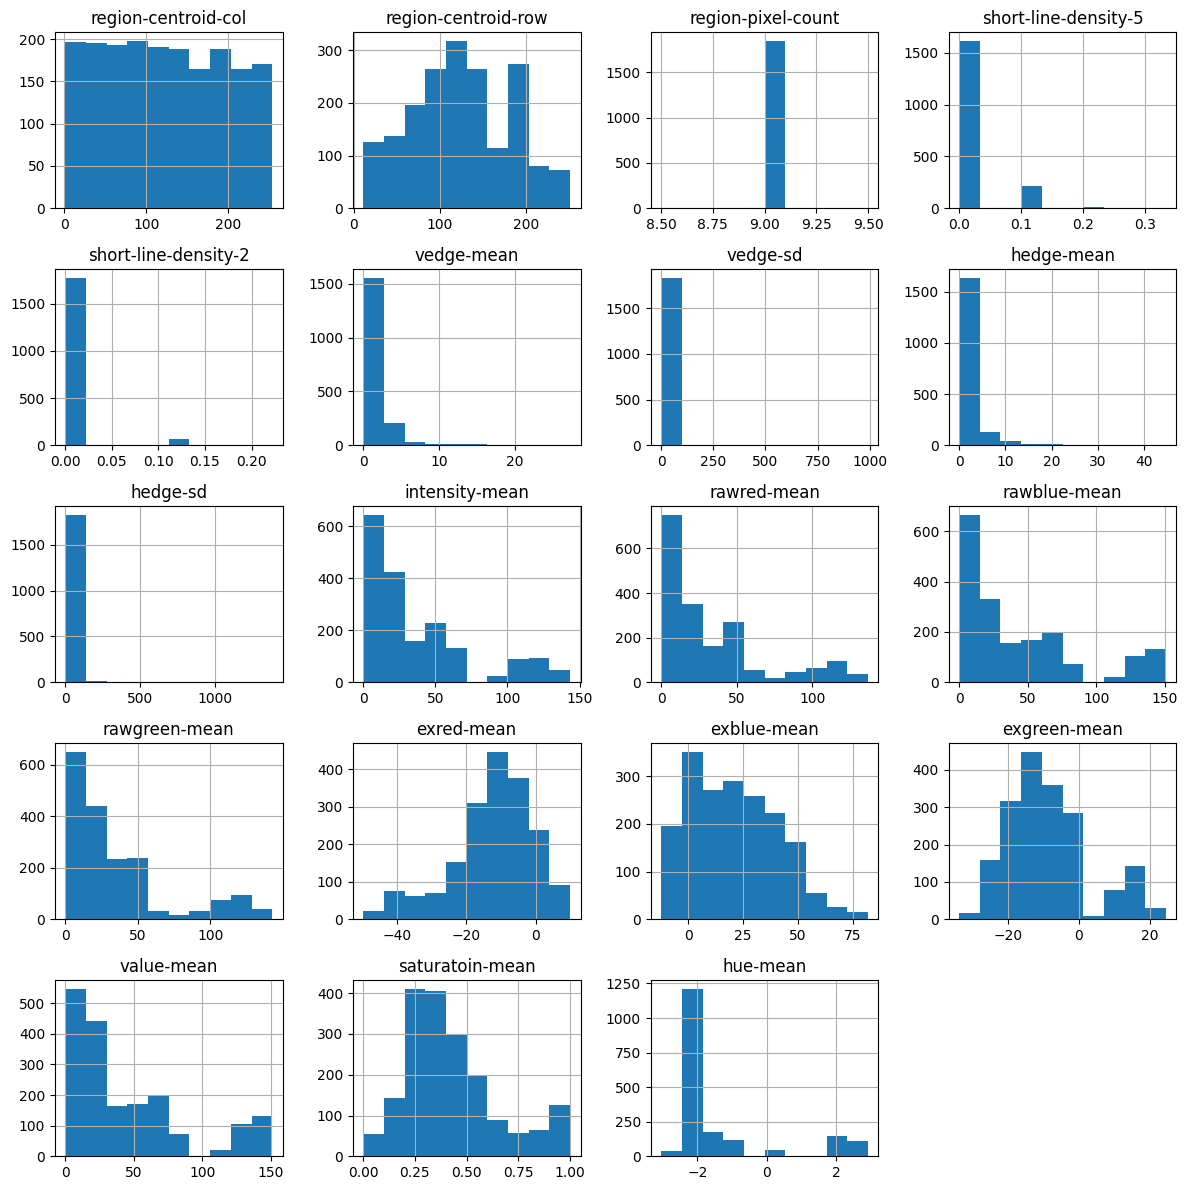

In [ ]:
train.hist(figsize=(12,12))
plt.tight_layout()
plt.show()

A continuación, estudiamos la distribución de los datos y respondemos a la pregunta de ¿están los datos balanceados?. O lo que es lo mismo, ¿existe el mismo número de instancias para cada etiqueta? Lo visualizaremos con un histograma donde se indica el número de etiquetas de cada ejemplo y su clase.

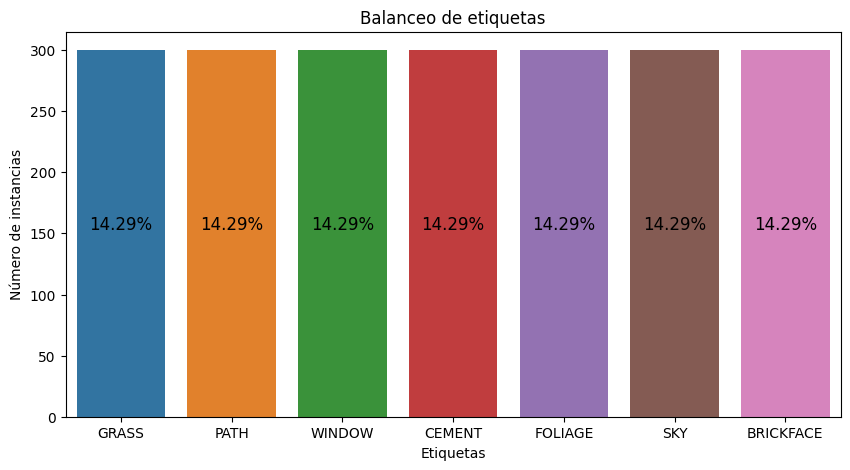

In [ ]:
# Cuenta el número de veces que aparece un rango de articulos compartidos y hace un muestreo
# Servirá para ver qué tan balanceados están los datos
def show_histogram(data, titulo, xlabel, ylabel, fontsize=12):
    fig, ax = plt.subplots(figsize=(10,5))

    # Obtener los valores de la columna objetivo
    ctarget = data[0].value_counts()

    # Calcular total
    total = ctarget.sum()

    # Calcular el porcentaje de datos en cada barra
    porcentaje = ctarget / total * 100

    # Crear el histograma utilizando seaborn
    sns.barplot(x=ctarget.index, y=ctarget.values)

    #plt.xticks(rotation=0)  # Rotación de 90 grados para las etiquetas del eje x

    # Mostrar el porcentaje en cada barra del histograma
    for i, v in enumerate(porcentaje):
      ax.text(i, int(ctarget.values[i]/2), f'{v:.2f}%', ha='center', va='bottom', rotation='horizontal', fontsize=fontsize)

    # Etiquetas y título
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(titulo)

    # Mostrar el histograma
    plt.show()

show_histogram(data, "Balanceo de etiquetas" , "Etiquetas", "Número de instancias", fontsize=12)

La respuesta es que observamos que no, todas las etiquetas están balanceadas. Esta cualidad de los datos facilita el proceso de aprendizaje y nuestro trabajo ya que si no estuvieran balanceadas deberíamos aplicar algunas técnicas para que esto no influya en el modelo. Por ejemplo, incluyendo penalización de pérdida ó una métrica que maneje esta situación como accuracy desbalanceado. En los casos extremos, podríamos pensar en repoblación utilizando SMOTE (Synthetic Minority Oversampling Technique).

### Gráficas de dispersión

Adicionalmente podemos visualizar gráficos de dispersión sobre varios pares de variables que nos parezcan relevantes. Por ejemplo, podemos intentar ver en qué columnas aparecen más qué etiquetas.

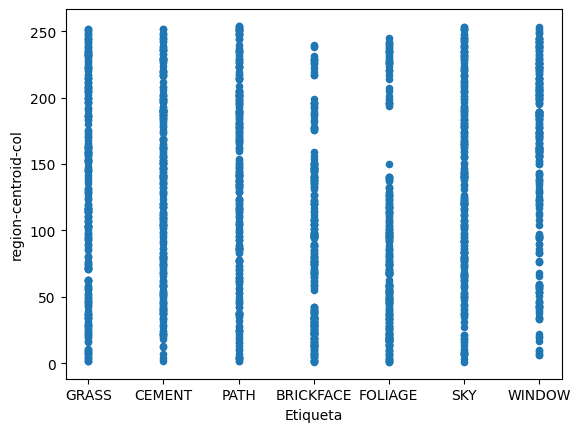

In [ ]:
# Crear el gráfico de dispersión
train.plot.scatter(x='Etiqueta', y='region-centroid-col')

# Mostrar el gráfico
plt.show()

Como se puede observar en la gráfica anterior, todos los elementos se encuentran repartidos a lo largo de la imagen. Es decir, nos podemos encontrar ya sea una ventana o camino tanto a la izquierda, derecha o centro de la imagen. Aunque si existe la particularidad de que si consideramos 0 la izquierda y 256 la derecha, vemos que entre la columna $150 - 200$ (centro-derecha de las imágenes) no se ha etiquetado ningún objeto de la clase $'FOLIAGE'$ (vegetación). Imaginamos que las imágenes eran paisajes donde había un equilibrio entre naturaleza y construcciones como casas.

Adicionalmente, podemos ver en qué filas aparecen más qué etiquetas.

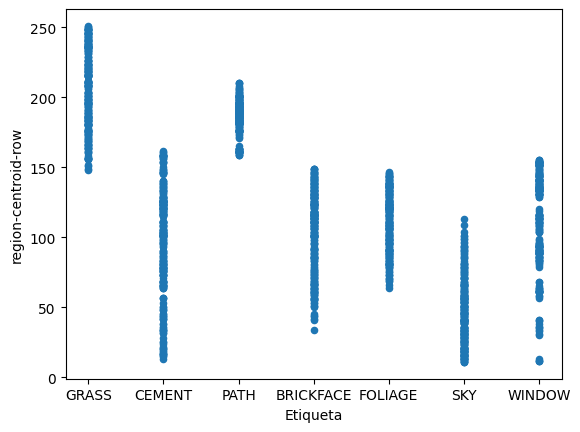

In [ ]:
# Crear el gráfico de dispersión
train.plot.scatter(x='Etiqueta', y='region-centroid-row')

# Mostrar el gráfico
plt.show()

Podemos observar que los siguientes patrones en la visualización:
- Los fragmentos de cielo se situan en las partes superiores de la imagen, a partir de la fila 130 a 0.
- Los fragmentos de hierba y camino se sitúan en las partes inferiores de la imagen, pues en la naturaleza se encuentra así.
- La vegetación (por ejemplo, árboles), y los edificios se encuentran en la parte media superior de la imagen. Las etiquetas $'FOLIAGE'$, $'CEMENT'$ y $'BRICKFACE'$ se encuentran en ese rango.
- Las ventanas se situan también en la parte superior de las imágenes coincidiendo en rango con la etiqueta $'CEMENT'$, y se encuentran distribuidas en intervalos discontinuos, pareciera que esto representa a las diferentes plantas de una casa. Nos permitimos suponer que todas las ventanas pertenecen a un edificio. Esto es un detalle importante ya que podríamos intuir que detrás de esto pueden existir diferentes problemas que debemos tener en mente.

Si las etiquetas de $'CEMENT'$, $'WINDOW'$ y $'FOLIAGE'$ están situadas tan cerca. Podríamos plantearnos que existe ruido en la extracción de las regiones. Juntando bordes de ventanas y cemento. Podríamos plantearnos que existe vegetación delante de las ventanas, añadiendo ruido en las extracciones.

A continuación, visualizamos los tres canales RGB de las imágenes. En la búsqueda de informarnos de cómo están los ejemplos ordenados tan solo teniendo en cuenta el color de cada instancia.

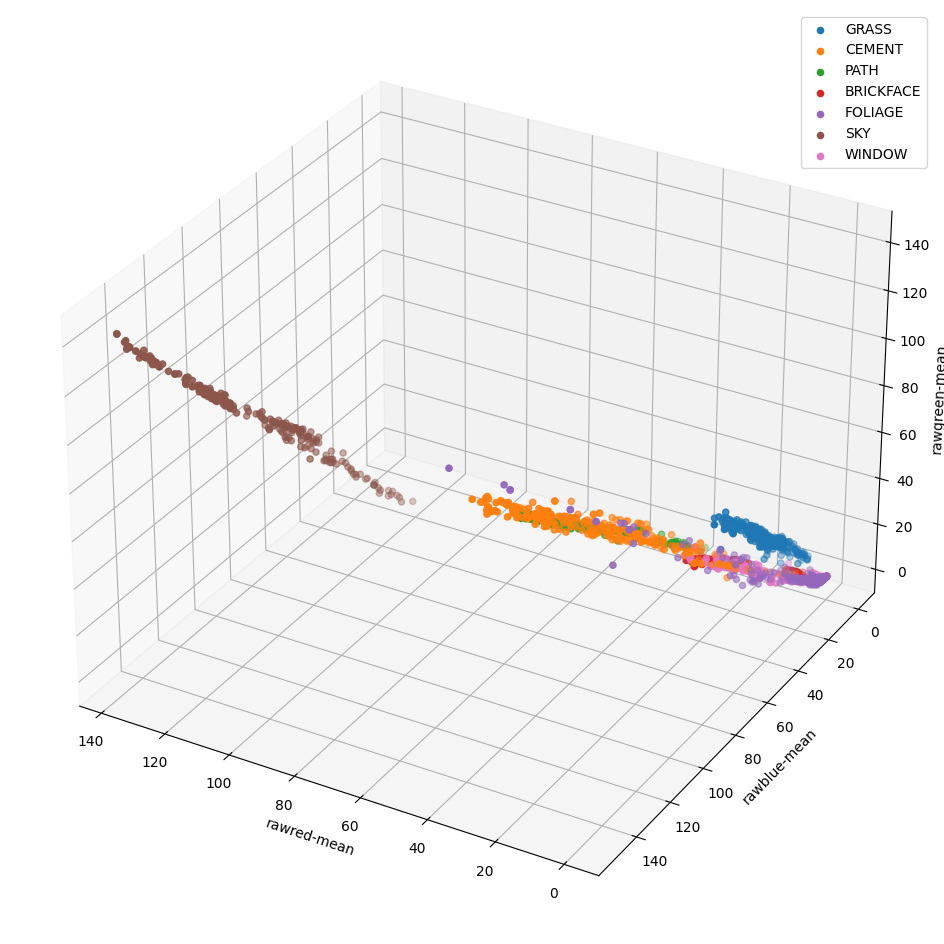

In [ ]:
# Crear una figura en 3D
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

# Obtener los datos correspondientes a cada eje
x = train['rawred-mean']
y = train['rawblue-mean']
z = train['rawgreen-mean']

# Obtener las etiquetas
labels = train['Etiqueta'].unique()

# Crear un diccionario de colores para cada etiqueta
label_colors = {
    label: plt.cm.tab10(i) for i, label in enumerate(labels)
}

# Iterar sobre los datos y las etiquetas para pintar cada punto
for label in labels:
    mask = train['Etiqueta'] == label
    ax.scatter3D(x[mask], y[mask], z[mask], color=label_colors[label], label=label)

# Agregar etiquetas a los ejes
ax.set_xlabel('rawred-mean')
ax.set_ylabel('rawblue-mean')
ax.set_zlabel('rawgreen-mean')

# Cambiar el ángulo de visión
ax.view_init(azim=120)

# Agregar leyenda
ax.legend()

# Mostrar el gráfico
plt.show()


Observamos que nuestro data set presenta objetos con multitud de tonalidades similares ya que observamos una escala medianamente continua entre los tres colores. Esto es un punto a favor ya que contamos con extracciones que añaden diversidad y podrían llevar una mejor generalización tras el proceso de aprendizaje.

Adicionalmente, si que vemos tres grupos de instancias con colores predominantes, estos tres grupos se corresponden con $'SKY'$, $'GRASS'$ y las otras clases. Con esta visualización podemos ver que las clases hierba y cielo están muy diferenciadas por lo menos a través de los canales RGB. Lo cuál es intuitivo por su fácil extracción (son clases con menos dificultades de ser extraidas). Esto nos indica que podríamos tener dificultades en las clases que se centran en la nube central si las otras característica no aportan información diferencial.

### Correlación de las variables

A partir de aquí, vamos a finalizar el análisis preguntándonos ¿existe correlación entre las variables continuas que tenemos? Para responder a esta pregunta, vamos a construir la matriz de correlación Pearson. La matriz de correlación de Pearson busca relaciones lineales entre variables, es decir, variables que multiplicadas por una constante sean otra variable.

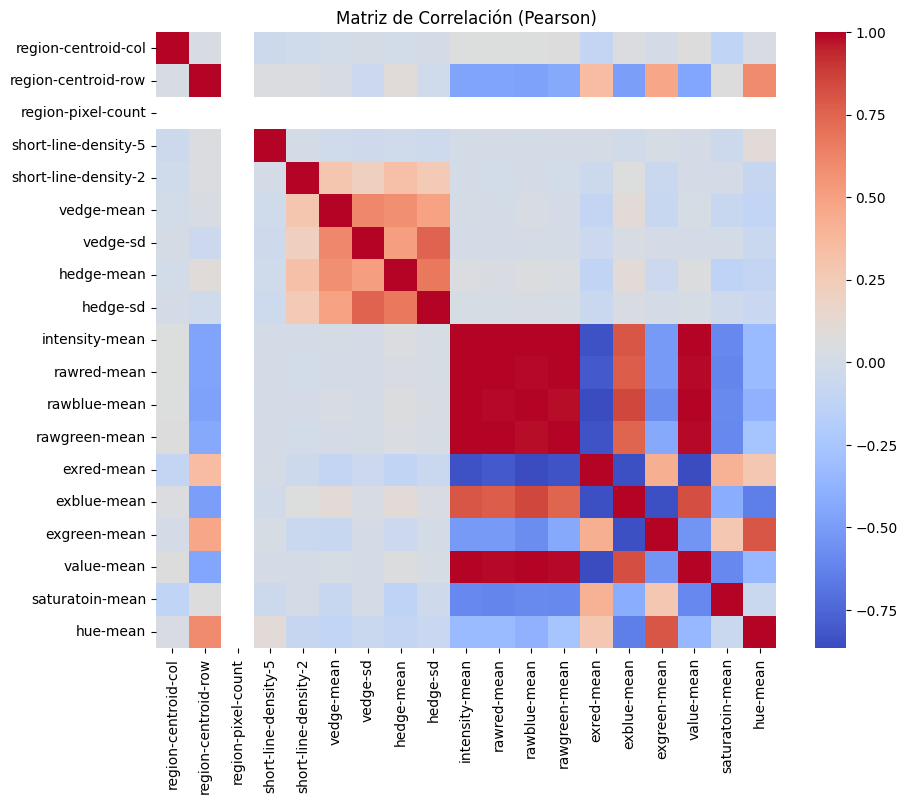

In [ ]:
# Visualizamos la correlacion de los datos

# Calcular la matriz de correlación de Pearson con las variables continuas
pearson_corr = X_(train).corr(method='pearson', numeric_only=False)

# Crear un mapa de calor de la matriz de correlación de Pearson
plt.figure(figsize=(10, 8))
sns.heatmap(pearson_corr, annot=False, cmap='coolwarm', annot_kws={"size": 8})
plt.title('Matriz de Correlación (Pearson)')
plt.show()

Como era esperable, un atributo consigo mismo está correlacionado. Por lo que la diagonal siempre nos da $1$.

Podemos ver ciertos atributos correlacionados. Podemos ver el grupo de atributos 'intensity-mean', 'rawred-mean', 'rawblue-mean', 'rawgreen-mean' y 'value-mean' están fuertemente correlacionados.

Adicionalmente podemos distinguir tres grupos de características, por un lado características relacionadas con el contraste de los píxeles. Vemos cierta correlación entre los atributos 'vedge-mean', 'vedge-sd' y 'hedge-mean', y apenas correlación de este grupo con el resto de atributos. Estos se encargan del contraste de los píxeles vertical, horizontalmente y su desviación estándar es esperable este resultado ya que entre ellos son muy parecidos pero era esperable que no hubiera relaciones entre características de color y constraste.

Por otro lado, características relacionadas con el color de los píxeles que 'raw-', 'ex-', 'saturation-mean' y 'hue-mean' tienen entre ellas diferentes correlaciones positivas y negativas.

Y por último vemos un grupo de variables no correlacionadas con ninguna otra, 'region-centroid-col', 'region-centroid-row y 'short-line-density-5'. Las dos primeras son las filas y columnas en las que se encuentran las extracciones de las regiones estas características no guarda ninguna relación con ninguna otra característica incluso tampoco entre ellas. La última mencionada se refiere al resultado de un algoritmo de detección de líneas de longitud 5 de bajo contraste, nuestras regiones son 3x3 así que es esperable que no exista una relación con ninguna otra característica obtenida en ese formato. Aún así esta característica puede ayudar a caracterizar a las etiquetas.




# <font color='blue'>2)  Preprocesado de los datos. Codificación, transformación y escalado.

Tras haber analizado la naturaleza del problema, es necesario plantearse ciertas preguntas previas que pueden ser críticas para el correcto funcionamiento de nuestras hipótesis.

### Codificación y decodificación

 Una de estas preguntas, es si debemos transformar los datos nativos de alguna forma más inteligente. Poder reducir la información de varias variables a menos variables ó a una, eliminar variables en las que podamos probar que no aportan información, tener una justificación fuerte para combinar la información de varias variables, aplicar one-hot enconding para poder trabajar en el caso de tener variables categóricas y continuas juntas en el conjunto ó transformar inteligentemente una posible distribución no lineal que tengamos al principio para poder aplicar modelos lineales y posteriormente destransformarla, son posibles ejemplos de este proceso.

La motivación es independientemente de tener una mayor o menor dimensionalidad. En este proceso, lo que queremos es transformar el conjunto considerando múltitud de técnicas y motivados por diferentes ideas para mejorar posteriormente el proceso de aprendizaje.

Puede ser difícil si no tenemos experiencia creando modelos en problemas similares saber a ciegas cómo responder esta pregunta. ¿Necesitamos codificar los datos?

Para atacar esta pregunta, optamos primero por revisar los trabajos que citan este dataset para comprobar si trabajan directamente con los datos nativos o hacían algún tipo de transformación. Los documentos que miramos fueron estos dos:

  1. Machine Learning and Knowledge Discovery in Databases
  2. Active Metric Learning from Relative Comparisons

Ambos directamente trabajan con los datos nativos, no realizando ninguna descripción/codificación con ellos, pues los consideran de suficiente alto nivel de descripción como para poder trabajar con ellos.

Seguimos estas pautas, de todas formas ya veremos el resultado cuando apliquemos validación cruzada cuando vayamos a entrenar los modelos. Si nos indica un mal resultado, tendremos que echar para atrás y volver a plantearnos cuestiones como esta.

### Valoración de la selección de un subconjunto de variables para el ajuste

Tras el análisis de las variables y con la baja dimensionalidad que tenemos consideramos sólo una ligera selección a un subconjunto de variables que excluye una de las variables. La variable 'region-pixel-count' cuenta los píxeles que se tratan por instancia, como todas nuestras instancias se corresponde al formato de 3x3, este valor es constante.

En este paso, a excepción de esta ligera modificación no incluimos otras novedades ya que no encontramos ninguna justificación para eliminar ningún otro atributo. Los datos son el recurso por el cual todo el trabajo se sustenta y todas las variables pueden estar enriqueciendo la información que tenemos de cada instancia. Sin encontrar otras relaciones ó argumentos que justifiquen otro tipo de selección, debemos confiar en los creadores del data set.

#### Atributos constantes

Como en el propio análisis observamos y comentamos el atributo 'region-pixel-count' es constante con un valor de 9 (todas las regiones son 3x3). Optamos por eliminarlo ya que es un atributo constante, y no aporta ninguna información relevante para el aprendizaje.

In [ ]:
# Eliminar atributo region-pixel-count, son todo 9
train = train.drop(['region-pixel-count'], axis=1, errors='ignore')
test = test.drop(['region-pixel-count'], axis=1, errors='ignore')

### Escalado de los datos

A continuación, pasamos escalar nuestros conjuntos de train y test. Teniendo en cuenta que el cálculo de la norma sólo lo vamos a computar con el conjunto de entrenamiento, y aplicar a test la misma norma calculada en entrenamiento. Este proceso es un proceso fundamental para que el proceso de aprendizaje se llevé a cabo.

Gracias a el escalado se consiguen gradientes más estables (el algoritmo se mueve más eficiente y con más precisión hacia el óptimo), se consigue una convergencia más rápida (el número de pasos en los que se actualiza el algoritmo es menor, al estar más cerca), justamente por esa propiedad de "estar cerca" se puede aplicar una regularización más efectiva ya que se asegura que la regularización tenga el mismo efecto en todos los puntos teniendo un rango similar y contribuyan de manera equitativa al modelo.

Algunos de los métodos de escalado más comunes son:

El **MinMaxScaler** es una función de la biblioteca Scikit-learn (sklearn) que se utiliza para realizar la normalización de datos. Esta función escala cada característica de forma independiente al rango especificado, que por defecto es (0,1). Para ello, se aplica la siguiente fórmula a cada valor de la característica:
$$
X_{MinMax} = \frac{X - X_{min}}{X_{max} - X_{min}}
$$

Donde X representa el valor original de la característica, X_min es el valor mínimo de la característica y X_max es el valor máximo de la característica. El resultado es un conjunto de datos normalizado en el rango (0,1), donde el valor mínimo de la característica se transforma en 0 y el valor máximo se transforma en 1.

La normalización es especialmente útil cuando las características tienen diferentes escalas o rangos iniciales, ya que ayuda a evitar que características con valores más grandes dominen el modelo durante el entrenamiento.

Por otro lado, el **StandardScaler** es otra función de la biblioteca Scikit-learn que se utiliza para realizar una transformación similar, pero con un enfoque diferente. En lugar de escalar los datos al rango (0,1), el StandardScaler aplica una transformación de "estandarización" a los datos, que los reescala de manera que tengan media cero y una desviación estándar de uno. Esto se logra utilizando la siguiente fórmula:

$$
X_{Standard} = \frac{X - X_{mean}}{X_{std}}
$$

Donde X es el valor original de la característica, $X_{mean}$ es la media de la característica y $X_{std}$ es la desviación estándar de la característica.

El hecho de que las características tengan una media de cero y una desviación estándar de uno (es decir, estén estandarizadas) puede favorecer a nuestros modelos de aprendizaje utilizados de las siguientes maneras:

1. Interpretación y comparación de coeficientes: los coeficientes de las características en un modelo se pueden interpretar directamente como la contribución relativa de cada característica a la variable objetivo. Al tener una escala común, es más fácil comparar y evaluar la importancia relativa de diferentes características en el modelo.

2. Estabilidad y velocidad de convergencia: evita que algunas características dominen sobre otras en el proceso de entrenamiento del modelo. Además, la estandarización puede ayudar a que los algoritmos de optimización converjan más rápido, ya que los gradientes y las actualizaciones de los pesos se vuelven más estables y consistentes.

3. Algoritmos sensibles a la escala: Algunos algoritmos, como la regresión logística, asumen que las características están en la misma escala o que tienen una distribución gaussiana. Estos algoritmos pueden dar más peso o importancia a características con una escala más grande. La estandarización con StandardScaler asegura que todas las características tengan una escala similar, lo que evita cualquier sesgo o desequilibrio en el modelo y permite que las características contribuyan de manera equitativa.

4. Regularización: La regularización es una técnica utilizada para evitar el sobreajuste en los modelos. Al estandarizar las características, se asegura que todas las características estén en la misma escala y la regularización se aplica de manera uniforme. Esto ayuda a controlar y regularizar la magnitud de los coeficientes, evitando la dominancia de características con una escala más grande y promoviendo una mejor generalización del modelo.

Por tanto el método de normalización utilizado será el StandardScaler de la biblioteca de SKlearn.
El objeto StandardScaler en scikit-learn tiene dos parámetros principales:

- with_mean: Este parámetro controla si se debe centrar los datos restando la media. Si se establece en True, el escalado se realiza restando la media de cada característica. Si se establece en False, la media no se resta y las características se escalan solo dividiendo por la desviación estándar. El valor por defecto es True, lo que significa que se realiza el centrado de los datos.

- with_std: Este parámetro controla si se debe escalar los datos dividiendo por la desviación estándar. Si se establece en True, las características se escalan dividiendo por la desviación estándar. Si se establece en False, no se realiza el escalado por la desviación estándar y solo se realiza el centrado de los datos. El valor por defecto es True, lo que significa que se realiza el escalado por la desviación estándar.

In [ ]:
# Normalizar

# Crear un objeto StandardScaler
scaler = StandardScaler()

# Calcular la media y la desviación estándar del conjunto de entrenamiento
scaler.fit(X_(train))

# Aplicar la normalización a los conjuntos de entrenamiento y prueba utilizando los valores de entrenamiento
train = join_(Y_(train), scaler.transform(X_(train)))
test = join_(Y_(test), scaler.transform(X_(test)))

# Mostrar las primeras filas del conjunto de entrenamiento original y normalizado
display(train.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,GRASS,-0.72486,0.978659,2.369957,-0.194118,-0.253454,-0.113699,0.146728,-0.105457,-0.378864,-0.408068,-0.515646,-0.182494,0.048468,-1.221046,2.015015,-0.410134,-0.436497,2.476763
1,CEMENT,-0.518298,-1.808729,-0.363926,-0.194118,-0.353663,-0.103627,-0.132842,-0.117948,0.75286,0.69035,0.876886,0.655988,-1.18088,1.44537,-1.261274,0.866782,-0.514508,-0.503186
2,PATH,1.450927,0.891553,-0.363926,-0.194118,-0.273496,-0.114596,0.853009,0.27165,-0.097156,-0.100639,-0.063458,-0.133171,0.048468,0.143431,-0.290878,-0.086996,-0.613945,-0.476015
3,CEMENT,0.073847,0.577972,-0.363926,-0.194118,0.187471,-0.048103,-0.059271,-0.107759,-0.357345,-0.411271,-0.271567,-0.404445,-0.191639,0.274194,-0.271662,-0.298078,0.01362,-0.526793
4,CEMENT,0.872553,-0.066611,-0.363926,-0.194118,0.107303,-0.080205,-0.309412,-0.124411,0.616896,0.703159,0.5917,0.557343,0.269367,0.342418,-0.848135,0.577521,-0.894133,-0.34723


### Reducción de dimensionalidad

En algunos problemas existe una dimensionalidad muy alta y que está asociada a tener características que no aportan información o incluso que puedan contener ruido, y no sean beneficiosas. Una de las técnicas más utilizadas para los conjuntos de datos de variables númericas es PCA (Principal Component Analysis) ó Análisis de variables principales. Esta es una técnica perteneciente a apredizaje no supervisado. Con ella podemos forzar a reducir nuestra dimensionalidad y probar a obtener de esta forma mejores resultados. Para ello, le especificamos una varianza la cual queremos mantener y  "limpiará" nuestras características para mantener sólo las más relevantes hasta esas características.

Nuestro problema no es dimensionalmente grande y tras el análisis de correlación vimos que obteniamos solo un grupo de características con correlación alta, las características asociadas a los canales RGB ('intensity-mean', 'rawred-mean', 'rawgreen-mean', 'rawblue-mean' y 'value-mean'), que parte de ellas visualizamos y vimos ciertos patrones.

Concluimos que aunque este grupo de tener una alta correlación, puede existir información sutil útil. Y ante la poca dimensionalidad y las pruebas desestimamos que PCA u otras técnicas de reducción de dimensionalidad tengan útilidad en nuestro problema.

# <font color='blue'>3)  Idoneidad de los modelos seleccionados

### Idoneidad de regresión logística

En la búsqueda de un modelo lineal que pueda funcionar en nuestro modelo, de entrada debemos rechazar a $PLA$ ó $Pocket$ ya que estamos trabajando con clasificación multietiqueta y $PLA$ sólo sirve para clasificación binaria. Como modelos lineales casi por descarte, siguiendo los estudiados en clase y dominamos mejor. Tenemos a **regresión logística** que aunque el nombre puede confundir, es utilizado en problemas de clasificación.

En el uso de **regresión logística** tenemos también un percetrón el cual recibe la combinación lineal de los parámetros del hiperplano y los valores de las características de las instancias, y tras usar la función de activación en lugar de intentar separar las clases por sí solo como $PLA$, da un número entre $0$ y $1$ que indica la probabilidad de pertenecer a una i-clase.

Estamos introduciendo la noción de probabilidad al usar este modelo, y es interesante reformular el problema de clasificación de esta forma, ya que como veíamos en el análisis nuestro formato 3x3 píxeles es limitado y puede haber instancias similares en varias características. Introducir un modelo que maneje la incertidumbre podría ser más preciso que uno que directamente da una clasificación "bruta" ya que en los casos en los que una instancia tenga similitud con diferentes etiquetas, aún con una probabilidad baja seguiría dando la más "probable" llevando en muchos casos a clasificarlo bien aún no estando el modelo tan seguro. Una técnica que encaja bien en la poca dimensionalidad, datos y sobre todo el formato tan limitado que tenemos.

Existen dos enfoques que nos llevan de un esquema de regresión logística binaria a un esquema multiclase. Estos son one-vs-rest y regresión logística multinomial. En el primero entrenamos $K$ clasificadores binarios distintos usando como función de activación, la función logística. Este se queda con el K-clasificador que dé la probabilidad más alta, prediciendo esa etiqueta K que corresponda a ese clasificador.

Sin embargo, el modelo que usaremos será regresión logística multinomial. Esta a diferencia de la anterior utiliza un único clasificador pero este en lugar de dar una probabilidad devuelve un vector de las probabilidades de pertenecer a cada clases y se queda con la clase de la probabilidad más alta. Formalmente, para una instancia específica con características $x$, el cálculo de la combinación lineal para la clase $i$ se realiza de la siguiente manera:

$$z_i = \sum_{j=1}^{D} w_{ij} \cdot x_j + b_i$$

donde $z_i$ es el valor de entrada de la clase $i$, $w_{ij}$ son el peso de esa característica para esa etiqueta, $x_j$ es la característica y $b_i$ el bias. Teniendo ahora una matriz de pesos, un vector de pesos por etiqueta, es decir 7 rectas que conforma la probabilidad de pertenecer a cada etiqueta.

La función de activación definida en este modelo es la siguiente, esta siempre devuelve un valor normalizado entre $0$ y $1$. Y cumple la propiedad que la suma de todas las probabilidades $P_{i}$ es $1$. Este resultado es simplemente un caso extendido de la formulación binaria de regresión logística: [Prueba consultada](https://en.wikipedia.org/wiki/Multinomial_logistic_regression#As_a_log-linear_model).


$$softmax(k, z_{1},..., z_{n}) = \frac{e^{z_k}}{\sum_{i=1}^{K} e^{z_i}}$$

A diferencia de "one-vs-rest", regresión logística multinomial tiene ciertas ventajas y optamos por el directamente, a continuación las enumeramos:

 - Eficiencia: Entrena un único modelo para todas las clases, lo que puede ser más eficiente computacionalmente que entrenar múltiples modelos independientes utilizando "one-vs-rest".

 - Coherencia de probabilidades:  Modela directamente las probabilidades conjuntas de todas las clases, lo que permite obtener estimaciones de probabilidad más coherentes y realistas para cada clase. En cambio, "one-vs-rest" puede producir probabilidades que no suman 1 debido a la independencia de los modelos.

- Mejor captura de relaciones entre clases: considera las relaciones y dependencias entre las clases durante el entrenamiento, lo que puede ser beneficioso cuando existe una estructura entre las clases. En "one-vs-rest", cada modelo se entrena de forma independiente sin tener en cuenta las relaciones entre las clases.

- Mayor interpretabilidad: En "one-vs-rest", se obtiene un modelo binario por cada clase, dificulta la interpretación directa de los pesos.





### Idoneidad de Perceptrón multicapa

Ante la imposibilidad de aplicar un único perceptrón en este problema multietiqueta, aún podemos insistir en la misma idea de fondo. Probémoslo con más capas.

El perceptrón multicapa es la unión de varios perceptrones en una red. Podemos ahora intentar construir o al menos aproximar un hiperplano que separe las clases con esta hipótesis. Aunque el enfoque de este modelo no incluye la probabilidad que nos daba RL (ya que no le vamos a introducir la misma función de activación), en estructuras de un tamaño considerable debería ser un aproximador interesante. La motivación detrás de construir perceptrón multicapa para este problema es el uso de amplio en la literatura de este modelo para problemas de este campo, segmentación de imágenes. Aunque los modelos actuales son muchos más avanzados que el usado.

Buscaremos iterativamente ciertos tamaños de las estructuras de red y nos basaremos en la función de activación $ReLU$ ya que a diferencia de otras funciones de activación como la función sigmoide o la tangente hiperbólica, la función ReLU no satura en la región positiva. Esto significa que no hay un límite superior en la salida de la función ReLU, lo cual evita el problema del desvanecimiento del gradiente y permite un mejor entrenamiento de la red.

La función ReLU tiene la propiedad de activar solo un subconjunto de las unidades en una red neuronal. Esto conduce a una representación más dispersa, que puede ser beneficioso al reducir la redundancia y complejidad en la representación de los datos.

Además al ser una operación simple es eficiente usarla, su interpretación es fácil y tiene uso común en la literatura. La función ReLU se presenta a continuación:

$$ReLU(x) = max(0, x)$$

Si $x$ es la entrada de las características ó la salida de la anterior capa, $W_1$ es el peso asociado a esa neurona y $b_1$ el biases. La expresión que se evalúa en cada neurona es la siguiente:
$$H = \text{ReLU}(W_1 \cdot x + b_1)$$
Y la salida de esa neurona es
$$y = W_2 \cdot H + b_2$$

Utilizaremos $SGD$ gradiente descendente estocástico para encontrar los pesos. El perceptrón multicapa utiliza el algoritmo del backpropagation para actualizar los pesos en su entrenamiento.

### Idoneidad de Random Forest

En la búsqueda de prueba de otros modelos no lineales que puedan ayudarnos a resolver el problema nos planteamos la opción de Random Forest. Como vimos en el punto 1 el data set estaba bien procesado pero desconfiábamos de la calidad de las extracciones, de la calidad de las imágenes en esa época y como ya hemos mencionado sabemos que es un problema las propias limitaciones del formato.

Planteamos usar Random Forest ya que es modelo más idóneo para tratar con el ruido de unas posibles extracciones mal seleccionadas. Random Forest es capaz de manejar conjuntos de características que contienen características irrelevantes o ruidosas. Mediante la selección aleatoria de características en cada árbol, el modelo puede ignorar características irrelevantes o ruidosas que pueden afectar negativamente a la precisión de los árboles de decisión individuales.

Random Forest tiene una mayor resistencia al sobreajuste en comparación con los árboles de decisión individuales. El muestreo con reemplazo y la combinación de múltiples árboles ayudan a reducir la varianza y la tendencia de los modelos a memorizar los datos de entrenamiento. Esto permite una mejor generalización del modelo a datos no vistos, lo que es especialmente útil cuando se trabaja con conjuntos de datos pequeños o ruidosos.

Con Random Forest construiremos un árbol de decisión donde cada nodo representará una región $R_m$ con $N_m$ ejemplos tal que la proporción de una clase $k$ en un nodo $m$ es:

$$\hat{P_{mk}} = \frac{1}{N_m} \cdot \sum_{x_i\in R_m}{\mathbb{I}[Y_i=k]}$$


Si representarámos nuestro árbol en D-dimensiones siendo D el número de características sería un montón hiperplano seccionado regiones del espacio con el objetivo de separar las diferentes clases.

Después de eso se clasifica los ejemplos de un nodo concreto (región en el espacio) siguiendo la clase mayoritaria de ese nodo $m$.
$$k(m)=argmax(\hat{P_{mk}})$$

Pero para llegar a asignar una etiqueta a un nodo con el criterio pasado, se utiliza una medida de impureza de los nodos para decidir si un nodo debe dividirse en subnodos más pequeños o si debe ser tratado como un nodo terminal (hoja) y asignarle una clase específica. La idea es que si un nodo tiene una entropía baja, significa que las clases están bien separadas y, por lo tanto, no se requiere una mayor subdivisión. Por otro lado, si la entropía es alta, significa que las clases están mezcladas y se necesita una división adicional para lograr una clasificación más precisa.

Como medida de impureza y criterio de parada hemos optado por la cross-entropy que tiene la siguiente expresión:
$$Q_m(T) = - \sum_{k=1}^{K}{\hat{P_mk}\cdot log(\hat{P_mk})}$$

Ya que al minimizar la entropía cruzada, se busca ajustar las probabilidades predichas por el modelo a las probabilidades reales de las clases que puede conducir a una mayor separación entre las clases, ya que el criterio de impureza está directamente relacionado con la discrepancia entre las probabilidades. Si bien la impureza de Gini también puede ayudar a separar las clases, puede no ser tan sensible a las diferencias sutiles en las distribuciones de clases.

Hemos visto que nuestro conjunto tenía variables con una correlación muy alta donde obtener información de estas se basa en cambios muy sutiles. Optamos por cross-entropy por estas razones.



### Idoneidad de Gradient Tree Boosting

Gradient Tree Boosting es una generalización de boosting a funciones de pérdida diferenciables arbitrarias. Consideramos esta alternativa tras probar random forest debido que en nuestro problema no tenemos una gran dimensionalidad y tampoco muchos datos. Estas que son las mayores ventajas que ofrece Random Forest en comparación a Gradient Tree Bossting. Sin embargo, Gradient Tree Boosting puede ofrecer las siguientes ventajas.
 - Tiende a tener un rendimiento predictivo más alto que Random Forest en problemas de clasificación. Debido a que se enfoca en corregir los errores cometidos por los modelos anteriores.
 - Gradient Tree Boosting ofrece una mayor flexibilidad en el ajuste de hiperparámetros en comparación con Random Forest. Puedes ajustar parámetros como la tasa de aprendizaje, la profundidad del árbol y el número de estimadores de manera más fina para optimizar el rendimiento del modelo.

 Por ello, su motivación de incluirlo como un modelo a elegir. Su funcionamiento principal es la mejora a través de $SGD$ de los pesos de cada región. Este algoritmo construye un modelo aditivo por etapas, permite la optimización de funciones de pérdida diferenciables arbitrarias. En cada etapa se ajustan $n\_clases$ sobre el gradiente negativo de la función de pérdida.

Siguiendo el siguiente esquema, para cada $i$ se computa:

$$ r_{im} = - [\frac{\partial L(y_i, f(x_i))}{\partial f(x_i)}]_{f=f_{m-1}} $$

Se entrena un árbol de regresión a los etiquetas $r_{im}$ dando regiones terminales $R_{jm}$. Para cada una de ellas se computa:

 $$\Upsilon_{jm} = argmin \sum_{x_i \in R_{jm}}{L(y_i, f_{m-1}(x_i)+\Upsilon}$$

 Actualizando de la siguiente manera:
$$ f_m(x) = f_{m-1}(x) + \sum_{j=1}^{J_m}{\Upsilon_{jm} \cdot I(x \in R_{jm})}$$

Se obtiene un árbol de decisión equivalente a Random Forest pero el que se ha ido actualizando a través de un cálculo de gradiente que minimiza no una métrica de pureza sino una función de pérdida.

# <font color='blue'>4)  Métricas de error y función de pérdida

### Métricas generales a todos los modelos

Las métricas que usaremos serán las propias de los problemas de clasificación: accuracy, sensibility, specificity, matriz de confusión y F1-score.

1. Accuracy (Precisión): es el porcentaje de ejemplos positivos o negativos que predice nuestro modelo bien en una muestra. Como métrica es la primera que debemos tener en cuenta, ya que es lo obvio. Pero necesita de ser interpretada usando otras, ya que la distribución de la muestra puede influir en esta y por ende en su interpretación. Por ejemplo, si tenemos una muestra con $90$ elementos positivos y $10$ negativos, que tenga un accuracy del $90\%$ por si sólo puede significar dos cosas que tiene un accuracy del $90\%$ y lo hace muy bien porque el otro $10\%$ restante eran ejemplos tanto positivos como negativos y no era sencillo predecirlos, ó que tiene un accuracy del $90\%$ pero lo único que hace es que a todos los predice como positivos.

2. Sensibility (Sensibilidad): responde a la pregunta “Among all the true positives, how many of them are indeed correctly captured by the model?”, es decir, ¿cuántos verdaderos positivos el modelo predice? En nuestro problema, calcularemos la sensibility de cada clase tomándola como la clase positiva.

3. Specificity (Especificidad): es el inverso de la sensibilidad. Responde a la pregunta: Among all the true negatives, how many of them are indeed correctly captured by the model?”, es decir, ¿cuántos verdaderos negativos el modelo predice? En nuestro problema, calcularemos la specificity de cada clase tomando todas las demás clase a ella como las negativas.

Como vemos la problemática que tenía el accuracy respecto la variabilidad de la distribución de la muestra, se puede responder interpretando conjuntamente Accuracy, sensibility y specificity. Ambos tres tienen que resultar en buenos resultados para que el resultado sea completo y fiable.
4. F1-score: es la media armónica de la precisión y la sensibilidad en una sola medida. De esta forma, podemos tener una medida adicional para poder interpretar el resultado de ambas. Y viene expresado por esta fórmula:
$$
F_1 \text{{-score}} = 2 \times \frac{{\text{{accuracy}} \times \text{{sensibility}}}}{{\text{{accuracy}} + \text{{sensibility}}}}
$$

5. Matriz de confusión: Trata los aciertos y errores con recompensas o penalizaciones. En el contexto de nuestro problema, consideramos que todas las clases son igualmente importantes. No obstante, podemos intuir que existen clases más parecidas a otras. La clase 'grass' (hierba) y la clase 'foliage' (vegetación) son semánticamente muy parecidas al igual que las clases 'brickface' y 'cement', incluimos esta métrica para poder interpretar los errores poniéndolos en contexto de sus clases.

Para obtener dichos resultados, de nuevo se importan de la librería sklearn los métodos **classification report(Y, predictions) y confusion matrix(Y, predictions)**

### Funciones de pérdida de cada modelo

#### Regresión logística

El uso de regresión logística multinomial tiene asociada la función de pérdida cross-entropy loss, que tiene la siguiente expresión:

$$L(y, \hat y) = - \sum (y \cdot log(\hat y))$$

Donde:

- $y$ es un vector one-hot que representa la etiqueta verdadera de la clase.
- $\hat y$ es un vector de probabilidades predicho por el modelo para cada clase.
En lugar de utilizar una única función de pérdida para el problema de clasificación multiclase, se calcula la entropía cruzada para cada clase y se suma el resultado total.

El objetivo del modelo de regresión logística multinomial es minimizar la función de pérdida de entropía cruzada, lo que implica encontrar los pesos que maximicen la probabilidad de que los datos observados se ajusten a las predicciones del modelo para todas las clases.

Desarrollando más la expresión anterior obtenemos (que representa la verdadera función de pérdida a bajo nivel):
$$ L(y_{ij}, p_{ij}) = - \sum_{i=1}^{N}\sum_{j=1}^{C} y_{ij} \log(p_{ij})$$

#### Perceptrón Multicapa y Gradient Tree Boosting

Implementaremos al perceptrón multicapa llamado a $sklearn.neural\_networks.MLPClassifier$, en su documentación no específica qué función de pérdida utiliza pero revisando el código fuente del método encontramos esta asignación loss="log_loss". Por lo que usa, la misma función de pérdida que en regresión logística multinomial, la que hemos mencionado anteriormente.

Respecto a Gradient Tree Boosting por defecto también llama a $log\_loss$. Mantendremos a esta opción para poder comparar los modelos más fielmente.

Como vimos en la idoneidad de los modelos, **Random Forest** no tiene una función de pérdida asociada. En lugar de eso seguía un esquema medición de impurezas de cada nodo del árbol.

# <font color='blue'>5)  Idoneidad de la regularización usada

Estudiada en teoría como un paso casi obligatorio, la regularización es un proceso heurístico que tiene una conexión directa con optimización modificamos nuestro modelo para permitir que generalice mejor. Paliando el posible ruido que tenga el data set. Por defecto, aunque depende en mayor o menor medida del análisis que hagamos del data set y de las variables debemos suponer que siempre existe ruido en nuestro data set. Por ello cobra tal importancia, ya que si aplica bien mejorará nuestra generalización siempre.

Por lo tanto, una de las decisiones que tenemos que tomar es elegir el tipo de regularización que queremos aplicar a nuestro modelo. Existen dos tipos principales.

La regularización L2, también conocida como regularización de Tikhonov o de descomposición de valor singular, se basa en agregar un término a la función de pérdida del modelo que penaliza los coeficientes del modelo al cuadrado. Esto tiene el efecto de forzar los coeficientes a ser más pequeños, distribuyendo la penalización de manera uniforme entre todos los coeficientes. La regularización L2 tiende a producir modelos con coeficientes más pequeños y suaves, lo que puede ayudar a prevenir el sobreajuste (overfitting) en conjuntos de datos con ruido o con muchas variables importantes.

Por otro lado, la regularización L1, también conocida como regularización de la norma L1 o regularización de LASSO (Least Absolute Shrinkage and Selection Operator), agrega un término a la función de costo que penaliza los coeficientes del modelo de acuerdo con su valor absoluto. Esto tiene el efecto de forzar algunos coeficientes a cero, lo que conduce a una selección automática de características, ya que los coeficientes correspondientes a características menos relevantes se vuelven exactamente cero. La regularización L1 es útil cuando deseas realizar una selección de características y reducir la complejidad del modelo al eliminar características irrelevantes.

En este problema nos hemos decantado por regularización L2 (Ridge) debido a que queremos que todas las variables del data set sean tenidas en cuenta. Y no pensamos que nos pueda ayudar la regularización LASSO ya que debido a la baja dimensionalidad y la naturaleza de las variables no existen variables predominantes que con un poco de ruido impidan que la información de otras variables sea sesgada, y generalice peor.


La expresión de la regularización L2 ó de Tikhonov que añadimos a nuestra función de pérdida se calcula siguiendo la siguiente expresión
$$
\hat \beta^{ridge}= \underset{\beta}{argmin} \left ( F_{loss} + \lambda \sum_{j=1}^{p}\beta_j^2 \right )
$$

Desarrollando la función de pérdida de regresión logística multinomial de la expresión obtenemos:
 $$ \hat \beta^{ridge} = - \sum_{i=1}^{N}\sum_{j=1}^{C} y_{ij} \log(p_{ij}) + \lambda \sum_{j=1}^{C}\sum_{k=1}^{P}\beta_{jk}^2$$

 $\lambda$ es uno de los hiperparámetros más importantes que buscaremos en la experimentación de hipótesis para todos los modelos, a excepción de Random Forest.

# <font color='blue'>6)  Experimentación en el conjunto de hipótesis

En este apartado experimentaremos con los distintos modelos y sus hiperparámetros, incluyendo al proceso de regularización como parte de esta experimentación. Crearemos unos métodos para generar un espacio de pruebas en los hiperparámetros que a partir de un desarrollo teórico no podamos deducir. Para hacer nuestra medición utilizaremos **VC (Validación cruzada)**, dividiremos nuestro conjunto de train en un número $cv$ de folds ó subconjunto, haremos 5 iteraciones que midan el rendimiento tomando como medición uno de los 5 subconjuntos que cambiará para cada iteracción y ajustando con el resto de subconjuntos. El rendimiento final será cada el promedio de cada iteracción, es decir, del rendimiento individual para cada subconjunto.

Validación cruzada tiene algunas ventajas frente a una estimación directa del rendimiento de nuestro modelo ya que:

1. **Evalúa la capacidad de generalización**: Al realizar múltiples iteraciones de entrenamiento y evaluación en diferentes subconjuntos de datos, la validación cruzada proporciona una estimación más precisa de cómo se desempeñará el modelo en datos no vistos. Esto ayuda a evaluar la capacidad de generalización del modelo y su capacidad para manejar diferentes variaciones y distribuciones de datos.

2. **Reducción del sesgo de selección de conjuntos de prueba**: Al utilizar una técnica de validación cruzada, se evita depender de un único conjunto de prueba para evaluar el rendimiento del modelo. Esto reduce la posibilidad de selección de conjuntos de prueba sesgados y proporciona una evaluación más imparcial del modelo.

3. **Mayor confiabilidad en la evaluación del modelo**: Al realizar la validación cruzada con un número suficiente de folds, se obtiene una estimación más robusta y confiable del rendimiento del modelo. La variabilidad en las métricas de evaluación se reduce y se obtiene una medida más precisa del rendimiento esperado del modelo en datos no vistos.

In [ ]:
def evaluate_model(predictions, r=5):

    accuracy = accuracy_score(Y_(train), predictions)

    precision = precision_score(Y_(train), predictions, average='macro')

    recall = recall_score(Y_(train), predictions, average='macro')

    f1 = f1_score(Y_(train), predictions, average='macro')

    return round(accuracy,r), round(precision,r), round(recall,r), round(f1,r)

In [ ]:
columns = ['Accuracy', 'Precision', 'F1', 'Recall']
def experimento(model, args={}):
  resultados = [] # Almacena métricas
  evaluaciones = [] # Almacena prediccion e Y


  param_combinations = list(product(*args.values()))

  columns = list(args.keys()) + ['Accuracy', 'Precision', 'F1', 'Recall']

  for param_combination in param_combinations:
    # Crear un diccionario con los parámetros combinados
    params = dict(zip(args.keys(), param_combination))

    # Carga los hiperparámetros del modelo
    m = model(**params)

    # Realizar las predicciones en el conjunto de prueba (Uso de cross validation)
    pred = cross_val_predict(m, X_(train), Y_(train), cv=5)

    # Evaluar el modelo utilizando las métricas de evaluación
    metricas = evaluate_model(pred)

    # Guardamos los resultados
    resultado = list(param_combination) + list(metricas)
    resultados.append(resultado)

  # Convertimos a vector
  resultados_v = np.array(resultados, dtype=object)

  # Creamos un DataFrame con los resultados
  df = pd.DataFrame(resultados_v, columns=columns) # Creamos df

  # Renombramos las filas con el nombre del modelo
  df = df.rename(index=lambda x: model.__name__)

  # Redondear los valores del DataFrame a 4 decimales
  display(df)


### Regresión Logística

Empezamos por aplicar el modelo lineal. A continuación, intentamos ajustar regresión logística. Utilizamos el solver 'sag' Stochastic Average Gradient y especificamos que use cross-entropy error con multi_class='multinomial'. El algoritmo SAG (Stochastic Average Gradient) implementado en Scikit-learn se basa en el descenso de gradiente estocástico, pero no permite especificar un tamaño de mini-batch.

El algoritmo SAG en Scikit-learn utiliza un enfoque de gradiente estocástico mejorado que mantiene un promedio de los gradientes pasados para mejorar la convergencia. Sin embargo, no permite el uso explícito de mini-batches. Y realmente no creemos que usar un tamaño muy distinto de mini-batch de lo que nos puede ofrecer por defecto el solver nos pueda aportar mejores resultados.

Para poner a prueba el modelo, lo importamos de la librería: sklearn.linear_model.LogisticRegression. El objeto LogisticRegression en scikit-learn tiene varios parámetros que se pueden ajustar para personalizar el comportamiento del modelo. Aquí se presentan algunos de los parámetros más comunes:

- penalty: Este parámetro controla la técnica de regularización aplicada al modelo. Puede tomar los valores 'l1', 'l2', 'elasticnet' o 'none'. La regularización ayuda a evitar el sobreajuste al penalizar los coeficientes más grandes. El valor por defecto es 'l2', que corresponde a la regularización de norma L2.

- C: Este parámetro controla la inversa de la fuerza de regularización. Valores más pequeños de C indican una regularización más fuerte, mientras que valores más grandes indican una regularización más débil. El valor por defecto es 1.0.

- solver: Este parámetro especifica el algoritmo utilizado para la optimización de los pesos. Puede tomar los valores 'newton-cg', 'lbfgs', 'liblinear', 'sag' o 'saga'. Cada algoritmo tiene sus propias características y puede ser más eficiente o eficaz para diferentes conjuntos de datos. El valor por defecto es 'lbfgs'.

- max_iter: Este parámetro controla el número máximo de iteraciones permitidas para que el algoritmo converja. Si el algoritmo no converge antes de alcanzar el número máximo de iteraciones, se mostrará una advertencia. El valor por defecto es 100.

- multi_class: Este parámetro indica cómo se debe tratar un problema de clasificación con múltiples clases. Puede tomar los valores: 'multinomial' para una estrategia multinomial, 'ovr' para el enfoque "uno contra todos" y auto para que se elija automáticamente el enfoque adecuado. La estrategia multinomial ajusta un modelo logístico para cada clase considerando la probabilidad conjunta, mientras que el enfoque "uno contra todos" ajusta modelos independientes para cada clase. El valor por defecto es auto, que selecciona automáticamente la estrategia según los datos.

- class_weight: Este parámetro permite asignar pesos diferentes a las clases para abordar el desequilibrio de clases en los datos. Puede tomar los valores 'balanced' (equilibra automáticamente los pesos según la frecuencia de las clases) o un diccionario que asigna pesos específicos a cada clase. El valor por defecto es None, lo que significa que no se aplica un peso específico a las clases.

Estos son solo algunos de los parámetros disponibles en LogisticRegression. También hay otros parámetros relacionados con la tolerancia de convergencia, la selección de características y el manejo de datos desequilibrados, entre otros.

Para el experimento nosotros usaremos penalty 'l2', solver 'sag' con un máximo de 5000 iteraciones y diferentes valores de regularización $C$.

El solver "sag" (Stochastic Average Gradient descent) es una función de optimización utilizada en la regresión logística. El objetivo de esta función es encontrar los pesos óptimos que minimicen la función de pérdida en la regresión logística. El algoritmo SAG utiliza técnicas de descenso de gradiente estocástico para iterativamente ajustar los pesos del modelo en busca de la solución óptima. A medida que avanza en las iteraciones, el solver SAG actualiza los pesos utilizando gradientes estocásticos promediados, lo que permite una convergencia más rápida en comparación con otros solvers. En resumen, el solver SAG es una función de optimización específica utilizada para encontrar los mejores pesos en la regresión logística.

In [ ]:
# Establecemos los hiperparámetros
args = { 'penalty' : ['l2'], 'solver' : ['sag'], 'max_iter' : [5000], 'C' : [1.0, 10.0, 100.0]}
# Realizamos el experimento
experimento(LogisticRegression, args=args)

,penalty,solver,max_iter,C,Accuracy,Precision,F1,Recall
LogisticRegression,l2,sag,5000,1.0,0.92803,0.92836,0.92801,0.92815
LogisticRegression,l2,sag,5000,10.0,0.94102,0.94203,0.94106,0.94143
LogisticRegression,l2,sag,5000,100.0,0.95022,0.95137,0.95031,0.95065


In [ ]:
# Crear una instancia del modelo de regresión logística
model_rl = LogisticRegression(penalty='l2', solver = 'sag', max_iter= 5000, multi_class='multinomial', C=100.0)

# Ajustar el modelo a los datos de entrenamiento
model_rl.fit(X_(train), Y_(train))

# Realizar predicciones en datos de prueba
y_pred = cross_val_predict(model_rl, X_(train), Y_(train), cv=5)

# Ver unos primero resultados
print(classification_report(Y_(train), y_pred))

# Ver matriz de confusión
print(confusion_matrix(Y_(train), y_pred))


              precision    recall  f1-score   support

   BRICKFACE       0.99      0.99      0.99       268
      CEMENT       0.95      0.92      0.93       270
     FOLIAGE       0.91      0.89      0.90       263
       GRASS       1.00      0.99      0.99       263
        PATH       0.99      1.00      0.99       265
         SKY       1.00      1.00      1.00       257
      WINDOW       0.82      0.87      0.85       262

    accuracy                           0.95      1848
   macro avg       0.95      0.95      0.95      1848
weighted avg       0.95      0.95      0.95      1848

[[264   0   0   0   0   0   4]
 [  1 248   0   0   0   0  21]
 [  0   3 234   0   0   0  26]
 [  0   0   1 260   2   0   0]
 [  0   0   0   1 264   0   0]
 [  0   0   0   0   0 257   0]
 [  1  11  21   0   0   0 229]]


Los resultados muestran las métricas de precisión, recall (tasa de verdaderos positivos), f1-score y soporte para cada clase en el problema de clasificación multiclase utilizando el modelo de regresión logística.

- Accuracy (exactitud): La exactitud general del modelo es del 95%, lo que indica que clasifica correctamente el 95% de los ejemplos en el conjunto de datos de prueba.

- Precision: Se observa que la precisión es alta en la mayoría de las clases, oscilando entre el 82% y el 99%. Las clases con mayor precisión son BRICKFACE, GRASS, PATH, y SKY.

- Recall: En general, el recall es alto para todas las clases, con valores que van desde el 87% hasta el 100%. Las clases con mayor recall son BRICKFACE, GRASS, PATH, SKY y WINDOW.

- F1-score: Proporciona una medida equilibrada del rendimiento del modelo. Los valores del F1-score están cerca de 1 para la mayoría de las clases, lo que indica un buen equilibrio entre precisión y recall.

- Soporte: El soporte indica el número de ejemplos de cada clase en el conjunto de datos de prueba. Se observa que hay un número similar de ejemplos para la mayoría de las clases, aunque la clase FOLIAGE tiene un soporte ligeramente mayor.

En general, los resultados muestran un buen desempeño del modelo de regresión logística en la clasificación multiclase del conjunto de datos. La mayoría de las clases tienen altas precisiones, recalls y F1-scores, lo que indica que el modelo es capaz de clasificar con precisión varias clases. Sin embargo, la clase WINDOW muestra una precisión y recall más bajos en comparación con otras clases, lo que podría indicar un desafío en la clasificación de esta clase específica.

El "macro avg" calcula el promedio de las métricas (precisión, recall, f1-score) para cada clase individualmente y luego toma el promedio de esos promedios. En otras palabras, trata cada clase por igual, independientemente de su tamaño o distribución en los datos. Esto puede ser útil cuando todas las clases tienen una importancia similar.

El "weighted avg" también calcula el promedio de las métricas para cada clase individualmente, pero tiene en cuenta el soporte (support), es decir, el número de muestras en cada clase. Calcula el promedio ponderado de las métricas, donde el peso se determina por la proporción de muestras en cada clase. En otras palabras, las clases con más muestras tienen más influencia en el cálculo del promedio ponderado. Esto puede ser útil cuando las clases tienen tamaños desiguales y se desea dar más importancia a las clases más representativas.

La matriz de confusión se lee de la siguiente manera:

- La diagonal principal de la matriz representa el número de instancias que se clasificaron correctamente para cada clase. Por ejemplo, se clasificaron correctamente 263 instancias de la clase BRICKFACE, 247 instancias de la clase CEMENT, etc.
- Los valores fuera de la diagonal principal indican las instancias que se clasificaron incorrectamente. Por ejemplo, se clasificaron erróneamente 5 instancias de la clase BRICKFACE como la clase WINDOW, etc.

De manera resumida, la matriz de confusión muestra cómo el modelo de regresión logística ha realizado las clasificaciones para cada clase. En este caso, la mayoría de las instancias se clasificaron correctamente, pero hubo algunos errores en la clasificación, especialmente en las clases CEMENT y WINDOW.

Tras observar que las etiquetas que más confunde el modelo son $'CEMENT'$ y $'WINDOW'$ probamos a introducir penalización de pérdida un poco mayor para esas dos clases, de forma que en entrenamiento se centre más en ellas. Aunque creemos que esto se debe a una mala definición de los bordes en la extracción y eso es ruido que no se solucionaría con esta técnica. Se debería solucionar con regularización pero a la misma vez regularizar hemos comprobamos que hacerlo con un $\lambda$ demasiado grande nos lleva a perder resultados.

In [ ]:
# Pesos
class_weights = {'BRICKFACE': 1.0,
                 'CEMENT': 1.5,
                 'FOLIAGE': 1.0,
                 'GRASS': 1.0,
                 'PATH': 1.0,
                 'SKY': 1.0,
                 'WINDOW' : 1.5}  # Ejemplo de pesos para cada clase

# Establecemos los hiperparámetros
args = { 'penalty' : ['l2'], 'solver' : ['sag'], 'max_iter' : [5000], 'C' : [100.0], 'class_weight' : [class_weights]}
# Realizamos el experimento
experimento(LogisticRegression, args=args)

,penalty,solver,max_iter,C,class_weight,Accuracy,Precision,F1,Recall
LogisticRegression,l2,sag,5000,100.0,"{'BRICKFACE': 1.0, 'CEMENT': 1.5, 'FOLIAGE': 1...",0.95076,0.95274,0.95083,0.95125


Como vemos, podemos desechar la idea de penalización de pérdida, ya que no obtenemos mejor resultados. Además no es la idea más natural, ya que en este problema de forma natural asumimos la predicción de todas las etiquetas valen igual

### Perceptrón multicapa

El perceptrón multicapa (MLP) en scikit-learn se implementa a través de la clase MLPClassifier para problemas de clasificación. Los principales parámetros del MLPClassifier en scikit-learn son los siguientes:

hidden_layer_sizes: Especifica la arquitectura de la red neuronal, es decir, el número de neuronas en una capa oculta. Se puede proporcionar como una tupla de enteros, donde cada entero representa el número de neuronas en una capa oculta. Por defecto, tiene una sola capa oculta de 100 neuronas.

activation: Especifica la función de activación utilizada en las capas ocultas. Puede ser 'relu' (Rectified Linear Unit), 'logistic' (función sigmoide) o 'tanh' (tangente hiperbólica). Por defecto, utiliza 'relu'.

solver: Especifica el algoritmo de optimización utilizado para ajustar los pesos de la red neuronal. Puede ser 'adam', 'lbfgs' (algoritmo de optimización de cuasi-Newton) o 'sgd' (descenso de gradiente estocástico). Por defecto, utiliza 'adam'.

alpha: Es el parámetro de regularización que controla la penalización por el término de regularización. Valores más altos de alpha implican una mayor regularización. Por defecto usa regularización L2 con valor de alpha=0.0001.

learning_rate: Especifica cómo se ajusta el tamaño de paso durante el proceso de optimización. Puede ser 'constant' (tamaño de paso constante), 'invscaling' (tamaño de paso decreciente) o 'adaptive' (ajusta automáticamente el tamaño de paso según la pérdida). Por defecto, utiliza 'constant'.

max_iter: Es el número máximo de iteraciones permitidas para la convergencia. Por defecto, tiene un valor de 200.

random_state: Es la semilla utilizada por el generador de números aleatorios para la inicialización de los pesos. Puede ser un entero o un objeto numpy.random.RandomState. Por defecto, es None.

Estos son solo algunos de los parámetros más comunes utilizados en el MLPClassifier de scikit-learn. Para nuestro problema utilizaremos el solver sgd (stochastic gradient descent), un número máximo de iteraciones de 2000, dos números de capas ocultas (14 y 49) y otros dos coeficientes de regularización

El solver SGD (Stochastic Gradient Descent) es utilizado como un algoritmo de optimización iterativo. En cada iteración, SGD actualiza los pesos de la red neuronal utilizando una muestra individual o pequeños lotes de muestras, lo que lo hace eficiente para grandes conjuntos de datos. La función de pérdida utilizada en SGD, específicamente en el MLPClassifier, es la "log loss" o "cross-entropy loss". Esta función mide la discrepancia entre las predicciones del modelo y las etiquetas reales durante el entrenamiento y el objetivo de SGD es minimizar esta función para mejorar la capacidad de clasificación del modelo.

In [ ]:
# Establecemos los hiperparámetros
args = { 'hidden_layer_sizes' : [(49,), (14,)], 'solver' : ['sgd'], 'max_iter' : [2000], 'alpha' : [0.0001, 0.000001]}
# Realizamos el experimento
experimento(MLPClassifier, args=args)

,hidden_layer_sizes,solver,max_iter,alpha,Accuracy,Precision,F1,Recall
MLPClassifier,"(49,)",sgd,2000,0.0001,0.94102,0.94115,0.94103,0.94092
MLPClassifier,"(49,)",sgd,2000,0.000001,0.94318,0.94335,0.94321,0.94297
MLPClassifier,"(14,)",sgd,2000,0.0001,0.93344,0.9337,0.93345,0.93354
MLPClassifier,"(14,)",sgd,2000,0.000001,0.9329,0.93374,0.93293,0.93328


In [ ]:
model_mlp = MLPClassifier(hidden_layer_sizes=(49,), activation='relu', solver='sgd', max_iter=2000, alpha=0.000001)

# Ajustar el modelo a los datos de entrenamiento
model_mlp.fit(X_(train), Y_(train))

# Realizar predicciones en datos de prueba
y_pred = cross_val_predict(model_mlp, X_(train), Y_(train), cv=5)

# Ver unos primero resultados
print(classification_report(Y_(train), y_pred))

# Ver matriz de confusión
print(confusion_matrix(Y_(train), y_pred))

              precision    recall  f1-score   support

   BRICKFACE       0.99      0.98      0.99       268
      CEMENT       0.94      0.93      0.93       270
     FOLIAGE       0.85      0.91      0.88       263
       GRASS       1.00      0.99      0.99       263
        PATH       0.99      1.00      0.99       265
         SKY       1.00      1.00      1.00       257
      WINDOW       0.83      0.79      0.81       262

    accuracy                           0.94      1848
   macro avg       0.94      0.94      0.94      1848
weighted avg       0.94      0.94      0.94      1848

[[263   0   0   0   0   0   5]
 [  1 250   2   0   1   0  16]
 [  1   3 239   0   0   0  20]
 [  0   1   0 260   2   0   0]
 [  0   0   0   0 265   0   0]
 [  0   0   0   0   0 257   0]
 [  1  13  41   0   0   0 207]]


Los resultados del modelo de Perceptrón Multicapa son los siguientes:

- Exactitud (Accuracy): La exactitud general del modelo ha aumentado a 0.95, lo que indica que clasifica correctamente aproximadamente el 95% de las instancias en el conjunto de datos de prueba.

- Precision: El modelo tiene una alta precisión en la mayoría de las clases, con valores que oscilan entre 0.85 y 1.00. Esto indica que el modelo clasifica correctamente la mayoría de las instancias en cada clase. La clase "BRICKFACE" tiene una precisión de 0.99, lo que indica un rendimiento muy sólido en esa clase.

- Recall: El recall también es alto en la mayoría de las clases, con valores que oscilan entre 0.91 y 1.00. Esto indica que el modelo identifica correctamente la mayoría de las instancias de cada clase. La clase "WINDOW" tiene el recall más bajo con 0.82, lo que sugiere que el modelo tiene cierta dificultad para identificar todas las instancias de esa clase.

- F1-score: El F1-score es alto en todas las clases, lo que indica un buen equilibrio entre precisión y recall. Los valores van desde 0.83 hasta 1.00, con la clase "SKY" obteniendo el F1-score perfecto de 1.00.

La matriz de confusión muestra los resultados de la clasificación realizada por el modelo de Perceptrón Multicapa (MLP). Cada fila representa la clase real, mientras que cada columna representa la clase predicha por el modelo.

Observamos que el modelo tiene un buen rendimiento en la mayoría de las clases, con valores altos en la diagonal principal de la matriz, lo que indica una alta concordancia entre las clases reales y las predichas. Sin embargo, existen algunas confusiones entre ciertas clases. Por ejemplo, el modelo confunde algunas instancias de la clase "BRICKFACE" y las clasifica incorrectamente como "WINDOW", resultando en 5 falsos positivos en esa clase.

Además, el modelo también presenta algunas confusiones entre las clases "CEMENT" y "FOLIAGE", clasificando incorrectamente 15 instancias de la clase "CEMENT" como "FOLIAGE". Similarmente, hay 19 instancias de la clase "FOLIAGE" clasificadas erróneamente como "WINDOW". Estas confusiones pueden deberse a similitudes en las características de las imágenes de estas clases.

En resumen, el modelo de Perceptrón Multicapa muestra un rendimiento excelente en la mayoría de las clases, con altas precisiones, recalls y F1-scores. Estos resultados indican que el modelo es capaz de clasificar correctamente las instancias en las diferentes clases del problema.

### Random Forest

El modelo Random Forest de scikit-learn tiene varios parámetros que se pueden ajustar para controlar su comportamiento. Algunos de los parámetros más importantes son:

- n_estimators: Especifica el número de árboles en el bosque. Por defecto, se establece en 100. Aumentar este valor puede mejorar el rendimiento del modelo, pero también aumenta el tiempo de entrenamiento.

- criterion: Indica la función de medida de calidad utilizada para evaluar la calidad de una partición en los nodos del árbol. Los valores posibles son "gini" y "entropy". Por defecto, se utiliza "gini".

- max_depth: Establece la profundidad máxima de los árboles en el bosque. Si no se establece ningún límite, los árboles se expandirán hasta que todas las hojas sean puras o hasta que todas las hojas contengan un número mínimo de muestras. Por defecto, no hay límite de profundidad.

- min_samples_split: Especifica el número mínimo de muestras requeridas para dividir un nodo interno. Si se proporciona un valor entero, se interpreta como el número mínimo absoluto de muestras. Si se proporciona un valor de punto flotante entre 0 y 1, se interpreta como una fracción del número total de muestras. Por defecto, se utiliza 2.

- max_features: Indica el número máximo de características a considerar al buscar la mejor partición en cada nodo. Puede ser un entero, un valor flotante o una cadena de texto. Si es un entero, se considera ese número exacto de características. Si es un valor flotante entre 0 y 1, se considera esa fracción del número total de características. Por defecto, se utiliza "auto", que es equivalente a "sqrt", lo que significa que se considera la raíz cuadrada del número total de características.

- bootstrap: El valor por defecto del parámetro en el modelo Random Forest de scikit-learn es True. Esto significa que, de manera predeterminada, se realiza el muestreo con reemplazo al construir cada árbol del bosque. Al utilizar el muestreo con reemplazo, se crea una mayor diversidad en los conjuntos de entrenamiento de cada árbol, lo que contribuye a un modelo más robusto y generalizable. El muestreo con reemplazo permite que algunas muestras se seleccionen múltiples veces, mientras que otras pueden no ser seleccionadas en absoluto. En conjunto, esto ayuda a reducir el riesgo de sobreajuste y mejora la capacidad del modelo para generalizar a nuevos datos.

Estos son solo algunos de los parámetros más comunes del modelo Random Forest en scikit-learn. En el experimento usaremos el criterion 'entropy' para usar la entropía cruzada como función de pérdida,varios valores de profundidad y de estimadores.

In [ ]:
# Establecemos los hiperparámetros
args = { 'criterion': ['entropy'], 'max_depth': [10, 20, 30], 'n_estimators': [20, 50, 100]}
# Realizamos el experimento
experimento(RandomForestClassifier, args=args)

,criterion,max_depth,n_estimators,Accuracy,Precision,F1,Recall
RandomForestClassifier,entropy,10,20,0.97024,0.97023,0.97026,0.97024
RandomForestClassifier,entropy,10,50,0.97294,0.97307,0.97301,0.973
RandomForestClassifier,entropy,10,100,0.97457,0.97462,0.97464,0.97461
RandomForestClassifier,entropy,20,20,0.96861,0.96867,0.96862,0.96857
RandomForestClassifier,entropy,20,50,0.97294,0.97293,0.97295,0.97292
RandomForestClassifier,entropy,20,100,0.97511,0.97523,0.97514,0.97513
RandomForestClassifier,entropy,30,20,0.96916,0.96915,0.96914,0.96912
RandomForestClassifier,entropy,30,50,0.97294,0.97298,0.97299,0.97294
RandomForestClassifier,entropy,30,100,0.97457,0.97466,0.97461,0.9746


In [ ]:
# Crear una instancia del modelo de regresión logística
model_rf = RandomForestClassifier(n_estimators = 100, criterion='entropy', max_depth=20)

# Ajustar el modelo a los datos de entrenamiento
model_rf.fit(X_(train), Y_(train))

# Realizar predicciones en datos de prueba
y_pred = cross_val_predict(model_rf, X_(train), Y_(train), cv=5)

# Ver unos primero resultados
print(classification_report(Y_(train), y_pred))

# Ver matriz de confusión
print(confusion_matrix(Y_(train), y_pred))

              precision    recall  f1-score   support

   BRICKFACE       0.98      1.00      0.99       268
      CEMENT       0.96      0.96      0.96       270
     FOLIAGE       0.94      0.95      0.94       263
       GRASS       1.00      0.99      1.00       263
        PATH       0.99      1.00      0.99       265
         SKY       1.00      1.00      1.00       257
      WINDOW       0.94      0.92      0.93       262

    accuracy                           0.97      1848
   macro avg       0.97      0.97      0.97      1848
weighted avg       0.97      0.97      0.97      1848

[[267   0   0   0   0   0   1]
 [  1 259   1   0   2   0   7]
 [  2   4 250   0   0   1   6]
 [  0   2   0 261   0   0   0]
 [  0   1   0   0 264   0   0]
 [  0   0   0   0   0 257   0]
 [  2   4  16   0   0   0 240]]


En Random Forest, se utiliza un conjunto de árboles de decisión que se entrenan de forma independiente y luego se combinan para tomar decisiones. La regularización en Random Forest se logra mediante el uso de las siguientes técnicas:

Muestreo aleatorio de características (Random Feature Subsets): En cada división de un árbol de decisión dentro del bosque, solo se considera un subconjunto aleatorio de características. Esto evita que los árboles se especialicen demasiado en un conjunto particular de características y promueve la diversidad entre los árboles.

Muestreo de datos (Bootstrapping): Para entrenar cada árbol en el bosque, se utiliza un muestreo con reemplazo de los datos de entrenamiento. Esto significa que cada árbol se entrena con una muestra aleatoria de los datos, lo que introduce variabilidad en el entrenamiento y reduce el riesgo de sobreajuste.

Estas técnicas de regularización inherentes a Random Forest ayudan a controlar el sobreajuste y a mejorar la generalización del modelo. La combinación de los árboles entrenados de forma independiente reduce la varianza del modelo y mejora la estabilidad de las predicciones.

Los resultados obtenidos muestran un rendimiento general muy bueno del modelo Random Forest en la clasificación de las diferentes clases.

- La precisión global (accuracy) del modelo es del 97%, lo que indica que clasifica correctamente el 97% de las muestras de prueba.

- La precisión (precision) es alta para todas las clases, lo que indica que el modelo tiene una capacidad sólida para predecir correctamente las muestras positivas de cada clase. La precisión oscila entre el 94% y el 100%, lo que indica una alta exactitud en las predicciones.

- El recall (recall) también es alto para todas las clases, lo que significa que el modelo puede identificar correctamente la mayoría de las muestras positivas de cada clase. Los valores de recall están en el rango del 95% al 100%, lo que indica una alta capacidad para recuperar correctamente las muestras relevantes.

- El valor de F1-score (f1-score), que combina la precisión y el recall, es también alto para todas las clases. Esto demuestra que el modelo tiene un equilibrio entre la precisión y el recall, lo que resulta en un buen rendimiento general.

La precisión, el recall y el F1-score son consistentes en todas las clases, lo que indica que el modelo es capaz de manejar de manera efectiva las diferentes clases y no muestra un sesgo significativo hacia ninguna clase en particular.

La matriz de confusión muestra cómo el modelo de Random Forest ha clasificado las muestras en cada clase. En general, se puede observar un rendimiento muy bueno del modelo, ya que la mayoría de las muestras se clasifican correctamente.

La diagonal principal de la matriz muestra los valores verdaderos positivos (TP) para cada clase, lo que significa que el modelo ha clasificado correctamente la mayoría de las muestras en cada clase. Los valores fuera de la diagonal principal representan las clasificaciones erróneas.

En general, la mayoría de las clasificaciones erróneas son pequeñas. Sin embargo, se puede notar que hay algunos errores en la clasificación entre las clases "BRICKFACE" y "WINDOW", así como entre las clases "CEMENT" y "FOLIAGE". Esto sugiere que puede haber cierta superposición en las características de estas clases, lo que dificulta su distinción para el modelo.

En resumen, los resultados obtenidos demuestran que el modelo Random Forest tiene un excelente desempeño en la clasificación de las diferentes clases en este conjunto de datos, con una alta precisión, recall y F1-score en todas las clases, y una precisión global del 97%.

### Gradient Tree Boosting

El modelo Gradient Boosting de scikit-learn tiene varios parámetros que se pueden ajustar para controlar su comportamiento. La mayoría de parámetros son muy similares a random forest. Algunos de los parámetros más importantes son:

- n_estimators: Especifica el número de árboles en el bosque. Por defecto, se establece en 100. Aumentar este valor puede mejorar el rendimiento del modelo, pero también aumenta el tiempo de entrenamiento.

- criterion: Indica la función de pérdida que usa el gradient boosting en nuestro caso, usaremos 'squared_error' al error cuadrático medio.

- max_depth: Establece la profundidad máxima de los árboles en el bosque. Si no se establece ningún límite, los árboles se expandirán hasta que todas las hojas sean puras o hasta que todas las hojas contengan un número mínimo de muestras. Por defecto, no hay límite de profundidad.

- loss: determina la función de pérdida utilizada durante el proceso de optimización del modelo de Gradient Boosting. Esta función de pérdida cuantifica la discrepancia entre las predicciones del modelo y los valores reales de las etiquetas de clase. En el caso del GradientBoostingClassifier, el valor "log_loss" utiliza la función de pérdida logística para problemas de clasificación binaria y la entropía cruzada para problemas de clasificación multiclase. Estas funciones de pérdida se enfocan en maximizar la probabilidad de clasificación correcta y son ampliamente utilizadas en problemas de clasificación. Sin embargo, también se proporciona la opción "exponential" que modifica la función de pérdida logística para dar más peso a las predicciones incorrectas, lo cual puede ser útil en situaciones de clasificación desequilibrada. La elección de la función de pérdida depende del problema específico y se recomienda utilizar el valor predeterminado a menos que haya una razón específica para utilizar la opción "exponential".

- max_features: Indica el número máximo de características a considerar al buscar la mejor partición en cada nodo. Puede ser un entero, un valor flotante o una cadena de texto. Si es un entero, se considera ese número exacto de características. Si es un valor flotante entre 0 y 1, se considera esa fracción del número total de características. Por defecto, se utiliza "auto", que es equivalente a "sqrt", lo que significa que se considera la raíz cuadrada del número total de características.

- learning rate: controla la contribución de cada árbol en la secuencia de boosting. Es un factor de ponderación que determina cuánto se ajusta el modelo en función de los errores residuales de los árboles anteriores. Un learning rate bajo reduce la influencia de cada árbol, lo que implica que se requieren más árboles para alcanzar la misma precisión. Por otro lado, un learning rate alto permite una rápida corrección de los errores, pero puede llevar a un sobreajuste si se utilizan demasiados árboles. El learning rate debe ajustarse cuidadosamente, ya que tiene un impacto significativo en el rendimiento del modelo. Un enfoque común es ajustar el learning rate junto con el número de estimadores (n_estimators) para encontrar un equilibrio entre el tiempo de entrenamiento y la precisión del modelo.

Estos son solo algunos de los parámetros más comunes del modelo Gradient Boosting en scikit-learn. En el experimento usaremos como criterio el error cuadrático y varios valores de learning rate, profundidad y número de estimadores.

In [ ]:
# Establecemos los hiperparámetros
args = { 'criterion': ['squared_error'], 'learning_rate':[0.1, 0.01],
         'max_depth': [3, 7], 'n_estimators': [100]}
# Realizamos el experimento
experimento(GradientBoostingClassifier, args=args)

,criterion,learning_rate,max_depth,n_estimators,Accuracy,Precision,F1,Recall
GradientBoostingClassifier,squared_error,0.1,3,100,0.9724,0.9724,0.97242,0.9724
GradientBoostingClassifier,squared_error,0.1,7,100,0.97132,0.9715,0.97138,0.9714
GradientBoostingClassifier,squared_error,0.01,3,100,0.94968,0.95201,0.94981,0.95042
GradientBoostingClassifier,squared_error,0.01,7,100,0.95887,0.95924,0.95886,0.959


In [ ]:
model_boos = GradientBoostingClassifier(criterion='squared_error', learning_rate=0.1, max_depth=3)

# Ajustar el modelo a los datos de entrenamiento
model_boos.fit(X_(train), Y_(train))

# Realizar predicciones en datos de prueba
y_pred = cross_val_predict(model_boos, X_(train), Y_(train), cv=5)

# Ver unos primero resultados
print(classification_report(Y_(train), y_pred))

# Ver matriz de confusión
print(confusion_matrix(Y_(train), y_pred))

              precision    recall  f1-score   support

   BRICKFACE       0.99      0.99      0.99       268
      CEMENT       0.96      0.96      0.96       270
     FOLIAGE       0.94      0.95      0.94       263
       GRASS       1.00      1.00      1.00       263
        PATH       1.00      1.00      1.00       265
         SKY       1.00      1.00      1.00       257
      WINDOW       0.92      0.91      0.92       262

    accuracy                           0.97      1848
   macro avg       0.97      0.97      0.97      1848
weighted avg       0.97      0.97      0.97      1848

[[265   1   0   0   0   0   2]
 [  0 260   1   0   1   0   8]
 [  1   2 249   1   0   0  10]
 [  0   0   1 262   0   0   0]
 [  0   1   0   0 264   0   0]
 [  0   0   0   0   0 257   0]
 [  2   6  15   0   0   0 239]]


Los resultados obtenidos muestran un rendimiento general muy bueno del modelo Gradient Boosting Classifier en la clasificación de las diferentes clases.

- La precisión global (accuracy) del modelo es del 97%, lo que indica que clasifica correctamente el 97% de las muestras de prueba.

- La precisión (precision) es alta para todas las clases, lo que indica que el modelo tiene una capacidad sólida para predecir correctamente las muestras positivas de cada clase. Las puntuaciones de precisión oscilan entre el 92% y el 100%, lo cual es bastante positivo.

- El recall (recall) también es alto para todas las clases, lo que significa que el modelo puede identificar correctamente la mayoría de las muestras positivas de cada clase. Los valores de recall están en el rango del 91% al 100%, lo cual indica una alta capacidad para recuperar correctamente las muestras relevantes.

- El valor de F1-score (f1-score), que combina la precisión y el recall, es también alto para todas las clases. Esto demuestra que el modelo tiene un equilibrio entre la precisión y el recall, lo que resulta en un buen rendimiento general. Las puntuaciones de F1-score se encuentran en el rango del 92% al 100%, lo cual es muy positivo.

La matriz de confusión muestra cómo el modelo de clasificación se desempeñó en la predicción de cada clase. En general, el modelo tuvo un buen rendimiento, clasificando correctamente la mayoría de las muestras en cada clase. Por ejemplo, en la clase "GRASS", todas las 263 muestras fueron clasificadas correctamente. Sin embargo, hubo algunos casos de confusión entre las clases "FOLIAGE" y "WINDOW", donde 11 muestras de "FOLIAGE" fueron incorrectamente clasificadas como "WINDOW" y 15 muestras de "WINDOW" fueron incorrectamente clasificadas como "FOLIAGE". Estos resultados indican que el modelo tiene dificultades para distinguir entre estas dos clases en particular y podría beneficiarse de una mayor atención en la mejora de la precisión en esas áreas específicas.

En resumen, los resultados obtenidos demuestran que el modelo Gradient Boosting Classifier tiene un excelente desempeño en la clasificación de las diferentes clases en este conjunto de datos, con una alta precisión, recall y F1-score en todas las clases, y una precisión global del 97%. Esto demuestra la capacidad del modelo para realizar una clasificación precisa y robusta en este problema de clasificación multiclase.

# <font color='blue'>7)  Selección de la mejor hipótesis

En este apartado evaluaremos con $test$ nuestras hipótesis para finalmente la tener la estimación del $Eout$ del modelo elegido. Esto nos servirá para llegar a una conclusión final de qué modelo consideraremos nuestro modelo final.

In [ ]:
test_pred = model_rl.predict(X_(test))

print(classification_report(Y_(test), test_pred))

print(confusion_matrix(Y_(test), test_pred))

              precision    recall  f1-score   support

   BRICKFACE       1.00      1.00      1.00        62
      CEMENT       0.92      0.90      0.91        60
     FOLIAGE       0.94      0.87      0.90        67
       GRASS       1.00      1.00      1.00        67
        PATH       0.97      1.00      0.98        65
         SKY       1.00      1.00      1.00        73
      WINDOW       0.83      0.88      0.86        68

    accuracy                           0.95       462
   macro avg       0.95      0.95      0.95       462
weighted avg       0.95      0.95      0.95       462

[[62  0  0  0  0  0  0]
 [ 0 54  0  0  2  0  4]
 [ 0  1 58  0  0  0  8]
 [ 0  0  0 67  0  0  0]
 [ 0  0  0  0 65  0  0]
 [ 0  0  0  0  0 73  0]
 [ 0  4  4  0  0  0 60]]


Cuando comprobamos con $test$ vemos que el accuracy es del $95\%$ el mismo resultado obtenido en entrenamiento con VC. Esto indica que nuestro es modelo no es optimista, una buena propiedad que podríamos conseguir. Y vemos que tenemos un resultado homogéneo en todas las métricas por lo que además de ser una tasa de precisión en la clasificación aceptable es coherente y consistente.

Analizando la matriz de confunsión los errores principales los vemos respecto la etiqueta $'WINDOW'$ era algo que esperabamos y que incluso intentamos solucionar, pero llegamos a la conclusión de que la opción más probable era de que se tratará de ruido, y nos veíamos en el compromiso de que un proceso de regularización más agresivo dañará el ajuste a las otras clases.

Por ello, tenemos un indicio de que este modelo podría rozar la optimalidad respecto el data set. Y realmente la solución de este problema se debería aplicar en la propia creación del data set.

In [ ]:
test_pred = model_mlp.predict(X_(test))

print(classification_report(Y_(test), test_pred))

print(confusion_matrix(Y_(test), test_pred))

              precision    recall  f1-score   support

   BRICKFACE       1.00      1.00      1.00        62
      CEMENT       0.92      0.92      0.92        60
     FOLIAGE       0.87      0.90      0.88        67
       GRASS       1.00      1.00      1.00        67
        PATH       1.00      1.00      1.00        65
         SKY       1.00      1.00      1.00        73
      WINDOW       0.85      0.82      0.84        68

    accuracy                           0.95       462
   macro avg       0.95      0.95      0.95       462
weighted avg       0.95      0.95      0.95       462

[[62  0  0  0  0  0  0]
 [ 0 55  1  0  0  0  4]
 [ 0  1 60  0  0  0  6]
 [ 0  0  0 67  0  0  0]
 [ 0  0  0  0 65  0  0]
 [ 0  0  0  0  0 73  0]
 [ 0  4  8  0  0  0 56]]


Con Perceptrón Multicapa obtenemos un resultado muy similar que RL. Aunque clasifica correctamente un ejemplo menos que RL. Los resultados de todas las metricas se mantienen consistentes.

Tenemos el misma problema que antes, nuestras la etiqueta que más falla sigue siendo $'WINDOW'$. Vemos que el cambio a un modelo no lineal no ha ayudado a resolver el problema, dando más fundamento a la razones que intuiamos.

In [ ]:
test_pred = model_rf.predict(X_(test))

print(classification_report(Y_(test), test_pred))

print(confusion_matrix(Y_(test), test_pred))

              precision    recall  f1-score   support

   BRICKFACE       0.98      1.00      0.99        62
      CEMENT       0.94      0.97      0.95        60
     FOLIAGE       0.98      0.97      0.98        67
       GRASS       0.99      1.00      0.99        67
        PATH       1.00      1.00      1.00        65
         SKY       1.00      1.00      1.00        73
      WINDOW       0.97      0.93      0.95        68

    accuracy                           0.98       462
   macro avg       0.98      0.98      0.98       462
weighted avg       0.98      0.98      0.98       462

[[62  0  0  0  0  0  0]
 [ 0 58  0  1  0  0  1]
 [ 0  1 65  0  0  0  1]
 [ 0  0  0 67  0  0  0]
 [ 0  0  0  0 65  0  0]
 [ 0  0  0  0  0 73  0]
 [ 1  3  1  0  0  0 63]]


Probamos con modelos que manejan mejor el ruido para intentar solucionar el problema con la etiqueta $'WINDOW'$ si vemos una mejor aproximación, obteniendo un $98\%$ en las métricas y siendo estos resultados igualmente consistentes.

Aunque no tratamos al modelo con una probabilidad una idea interesante utilizada en RL, vemos como seccionar partes del espacio da buenos resultados y dudamos de la escalabilidad de estos (si se aumentarán las etiquetas si seguiría obteniendo estos resultados) ya que claro tenemos que asumir que las instancias están en una disposición relativamente separable de esta forma. De lo contrario podríamos obtener un árbol muy grande.

Aun así este modelo ofrece la ventaja de su rápidez y su buen manejo de ruido especialmente importante en extracciones de imágenes de la época del problema que no tienen la calidad de la época actual.

Este modelo es un candidato fuerte a ser nuestro modelo final que competirá con el siguiente Gradient Tree Boosting.

In [ ]:
test_pred = model_boos.predict(X_(test))

print(classification_report(Y_(test), test_pred))

print(confusion_matrix(Y_(test), test_pred))

              precision    recall  f1-score   support

   BRICKFACE       0.97      1.00      0.98        62
      CEMENT       0.93      0.95      0.94        60
     FOLIAGE       1.00      0.96      0.98        67
       GRASS       1.00      1.00      1.00        67
        PATH       1.00      0.98      0.99        65
         SKY       1.00      1.00      1.00        73
      WINDOW       0.97      0.99      0.98        68

    accuracy                           0.98       462
   macro avg       0.98      0.98      0.98       462
weighted avg       0.98      0.98      0.98       462

[[62  0  0  0  0  0  0]
 [ 1 57  0  0  0  0  2]
 [ 0  3 64  0  0  0  0]
 [ 0  0  0 67  0  0  0]
 [ 0  1  0  0 64  0  0]
 [ 0  0  0  0  0 73  0]
 [ 1  0  0  0  0  0 67]]


Respecto Gradient Tree Boosting, obtenemos unos resultados muy parecidos a Random Forest. Sin embargo, este modelo clasifica un ejemplo mejor. Y parece ir mucho mejor que sus antecesores en la etiqueta que peor clasificaban $'WINDOW'$. Dando resultados coherentes y de calidad, a pesar de alto coste computacional pues es muy pesado.

Consideramos que este modelo es nuestro mayor candidato a modelo final debido a que la experimentación con los dos modelos basados en árboles daban buenos resultados y este a diferencia de Random Forest ha resuelto con mejores resultados la etiqueta más complicada. Esto es resultado de optimizar el árbol en lugar de hacerlo mayor, una estrategia que parece más viable si se quisiera ampliar el problema original a más etiquetas ó más variables de cada instancia. Y que se manifiesta en los resultados más diversos de fallo, indicando su mejor comprensión general del problema. Mejor generalización que podemos interpretar a partir de la matriz de confusión.

#### Baselines

En este apartado, vamos a construir métodos heurísticos simples para constrartar el buen desempeño del modelo con ellos. Y así darnos cuenta de su importancia. Construiremos un clasificador aleatorio.

In [ ]:
def generar_etiquetas_aleatorias(n):
    etiquetas = ['SKY', 'CEMENT', 'BRICKFACE', 'WINDOW', 'GRASS', 'PATH', 'FOLIAGE']
    array_etiquetas = []
    for _ in range(n):
        etiqueta_aleatoria = random.choice(etiquetas)
        array_etiquetas.append(etiqueta_aleatoria)
    return array_etiquetas

# Ejemplo de uso:
etiquetas_aleatorias = generar_etiquetas_aleatorias(len(Y_(test)))

print(classification_report(Y_(test), etiquetas_aleatorias))

print(confusion_matrix(Y_(test), etiquetas_aleatorias))

              precision    recall  f1-score   support

   BRICKFACE       0.13      0.13      0.13        62
      CEMENT       0.23      0.28      0.25        60
     FOLIAGE       0.21      0.16      0.18        67
       GRASS       0.22      0.21      0.22        67
        PATH       0.17      0.14      0.15        65
         SKY       0.08      0.08      0.08        73
      WINDOW       0.14      0.16      0.15        68

    accuracy                           0.16       462
   macro avg       0.17      0.17      0.17       462
weighted avg       0.17      0.16      0.16       462

[[ 8 11  7  5  8 13 10]
 [ 5 17  6  8 10  6  8]
 [ 8  6 11 10  8 13 11]
 [ 9  9  5 14  5 14 11]
 [ 5  8  9  8  9 12 14]
 [14 15  9  7  9  6 13]
 [13  9  6 11  5 13 11]]


Observamos que frente un comportamiento aleatorio que da $14\%-15\%$ en las métricas, nuestro mejor modelo da un $98\%$. Lo cual es un resultado que supera al baseline de forma significativa.

# <font color='blue'>8)  Valoración de los resultados

A continuación, valoraremos los resultados en función de la construcción de algunas visualizaciones como la curva de aprendizaje y la curva ROC para el resto de modelos.

La curva de aprendizaje muestra cómo evoluciona el rendimiento del modelo a medida que se aumenta el tamaño del conjunto de entrenamiento. En esta curva, generalmente se traza el error (o alguna métrica de rendimiento) en el eje y en función del tamaño del conjunto de entrenamiento en el eje x. La curva de aprendizaje es útil para detectar problemas de sobreajuste o subajuste, y para comprender cómo el modelo mejora a medida que se dispone de más datos de entrenamiento.

Por otro lado, la curva ROC (Receiver Operating Characteristic) muestra la relación entre la tasa de verdaderos positivos (sensibilidad) y la tasa de falsos positivos (1 - especificidad) a medida que se varía el umbral de clasificación en un modelo de clasificación en nuestro caso usando el esquema one-vs-rest respecto las etiquetas. La curva ROC es utilizada para evaluar y comparar modelos de clasificación, y proporciona una medida de cuán bien el modelo puede distinguir entre las clases.

Al analizar las curvas de aprendizaje, podemos obtener varias conclusiones importantes:

1. Sesgo y varianza: Una curva de aprendizaje puede ayudarnos a identificar si el modelo sufre de sesgo alto o varianza alta. Un modelo con alto sesgo se caracteriza por un bajo rendimiento tanto en el conjunto de entrenamiento como en el conjunto de prueba, lo que indica que no ha aprendido bien las relaciones subyacentes en los datos. Por otro lado, un modelo con alta varianza muestra una brecha significativa entre el rendimiento en el conjunto de entrenamiento y el conjunto de prueba, lo que indica un sobreajuste o falta de generalización.

2. Necesidad de más datos: Si el modelo muestra un rendimiento deficiente tanto en el conjunto de entrenamiento como en el conjunto de prueba, y las curvas de aprendizaje no han convergido, esto puede indicar que se requieren más datos de entrenamiento para mejorar el rendimiento.

3. Evaluación de la capacidad del modelo: Las curvas de aprendizaje nos permiten evaluar la capacidad del modelo para aprender de los datos. Si el rendimiento en el conjunto de prueba mejora a medida que se aumenta el tamaño del conjunto de entrenamiento, es un indicio de que el modelo tiene la capacidad de aprender de los datos y generalizar bien.


In [ ]:
# Curva de aprendizaje
def show_learningCurve(X_train, Y_train, model_, titulo, scr_ = "accuracy", cv_ = 5, trn_size_ = np.linspace(0.01, 1.0, 15)):
  """
  Muestra la curva de aprendizaje del modelo utilizando diferentes tamaños de conjunto de entrenamiento.

  Parámetros:
  - XTrain: Características del conjunto de entrenamiento.
  - YTrain: Objetivo del conjunto de entrenamiento.
  - model_: Modelo de aprendizaje a evaluar.
  - titulo: Título del gráfico.
  - cv_: Número de subdivisiones en la estrategia de validación cruzada.
  - scr_: Métrica de evaluación utilizada.
  - trn_size_: Tamaños del conjunto de entrenamiento para los que se calcula el puntaje.
  """
  # Se calcula la curva de aprendizaje
  sizes, training_scores, testing_scores = learning_curve(model_, X_train, Y_train, cv=cv_, scoring=scr_, train_sizes=trn_size_)

  # Cálculo de la media de los puntajes de entrenamiento y validación cruzada
  mean_training = np.mean(training_scores,axis=1)
  mean_testing = np.mean(testing_scores, axis=1)

  # Graficar la curva de aprendizaje
  plt.plot(sizes, mean_training, '--', color="b", label="Ein")
  plt.plot(sizes, mean_testing, color="g", label="Eout")

  plt.title(titulo)
  plt.xlabel("Training Set Size")
  plt.ylabel(scr_)
  plt.legend(loc="best")
  plt.tight_layout()
  plt.show()

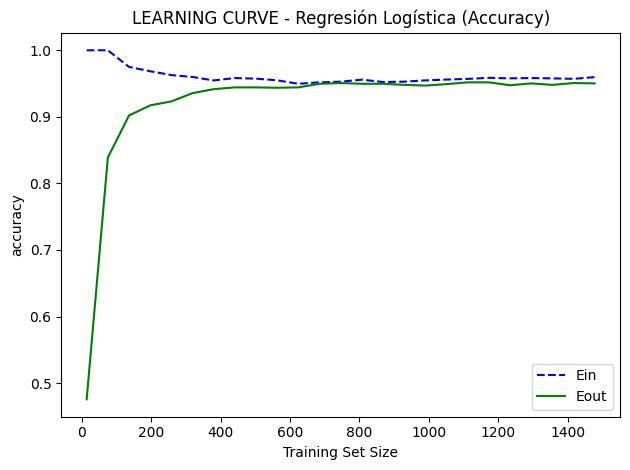

In [ ]:
show_learningCurve(X_(train), Y_(train), model_rl, "LEARNING CURVE - Regresión Logística (Accuracy)", trn_size_=np.linspace(0.01, 1.0, 25))

En el caso de la curva de aprendizaje de regresión logística, se observa lo siguiente:

- Inicialmente, el error de entrenamiento ($E_{in}$) tiene un accuracy perfecto (1) porque el modelo está aprendiendo de un número muy pequeño de ejemplos, lo que facilita su capacidad para ajustarse a esos datos de manera precisa. Por otro lado, el error de validación ($E_{out}$) comienza con un valor de accuracy bajo (0) porque el modelo aún no ha tenido suficientes ejemplos para aprender patrones generalizables.

- A medida que se incrementa el tamaño de la muestra de entrenamiento, los errores de entrenamiento y validación comienzan a converger. Es decir, $E_{in}$ disminuye mientras $E_{out}$ aumenta hasta que se encuentran en un punto donde tienen el mismo valor de accuracy en el tamaño de muestra 600 y 800. Esto indica que el modelo está aprendiendo a generalizar a partir de los datos de entrenamiento y su capacidad de ajuste se vuelve más similar al rendimiento en datos no vistos.

- Después de ese punto, los errores de entrenamiento y validación se separan muy brevemente, pero luego se estabilizan en un valor de accuracy de 0.95. Esto indica que el modelo ha alcanzado su capacidad de aprendizaje máxima con el conjunto de datos y no se espera que mejore significativamente a medida que se aumenta el tamaño de la muestra.

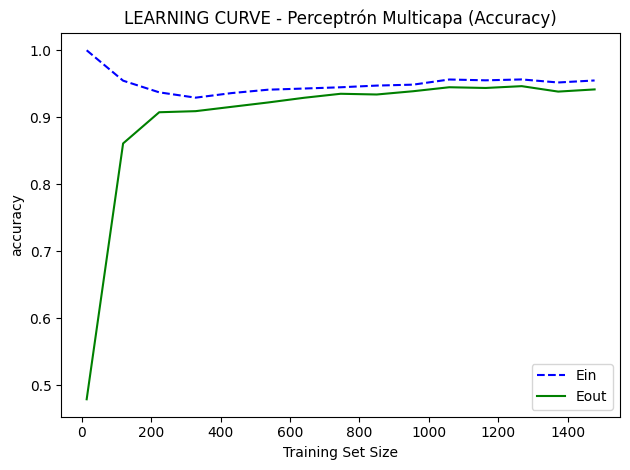

In [ ]:
show_learningCurve(X_(train), Y_(train), model_mlp, "LEARNING CURVE - Perceptrón Multicapa (Accuracy)")

En el caso de las curvas de aprendizaje del Perceptron Multicapa, se puede hacer el siguiente análisis:

- Inicialmente, el error de entrenamiento ($E_{in}$) muestra un accuracy perfecto (1), lo que indica que el modelo de Perceptron Multicapa es capaz de ajustarse de manera precisa a los datos de entrenamiento iniciales. Por otro lado, el error de validación ($E_{out}$) comienza en un valor de accuracy bajo (0), lo que sugiere que el modelo no logra generalizar bien a los datos no vistos al principio.

- A medida que se incrementa el tamaño de la muestra de entrenamiento, $E_{in}$ y $E_{out}$ comienzan a converger entre sí. Esto indica que el modelo está mejorando su capacidad de generalización a medida que se le proporciona más información a través de un mayor número de ejemplos. Con más ejemplos de entrenamiento, el Perceptron Multicapa puede aprender patrones más complejos y ajustarse mejor a los datos.

- En el tamaño de muestra 200, $E_{in}$ y Eout se estabilizan en un valor de accuracy de 0.9. Esto sugiere que el modelo ha alcanzado un punto donde ha aprendido la mayoría de los patrones presentes en los datos de entrenamiento y su capacidad de generalización se ha mejorado significativamente. Sin embargo, aún existe un pequeño margen de error en la clasificación de los ejemplos, lo que se refleja en el valor de accuracy de 0.9.

- Después de ese punto, $E_{in}$ y $E_{out}$ continúan aproximándose muy lentamente a medida que aumenta el tamaño de la muestra. Esto indica que el modelo sigue mejorando su capacidad de generalización, aunque a un ritmo más lento. Aunque la mejora es marginal, se observa un aumento en el valor de accuracy a medida que se agregan más ejemplos al entrenamiento.

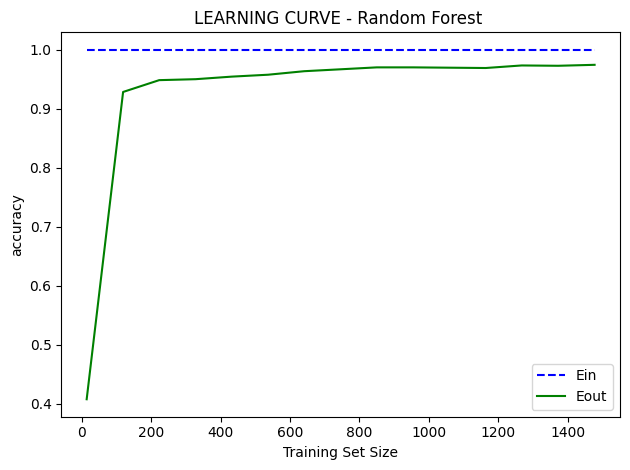

In [ ]:
show_learningCurve(X_(train), Y_(train), model_rf, "LEARNING CURVE - Random Forest ")

En el caso de las curvas de aprendizaje de Random Forest, podemos realizar el siguiente análisis:

- El error de entrenamiento ($E_{in}$) se mantiene en 1 independientemente del tamaño de muestra de entrenamiento. Esto ocurre porque Random Forest es capaz de ajustarse a los datos de entrenamiento a medida que se agregan más ejemplos, ya que cada árbol individual del bosque puede aprender perfectamente los datos de entrenamiento.

- El error de validación $E_{out}$ muestra un comportamiento interesante. Inicialmente, a medida que aumenta el tamaño de la muestra de entrenamiento, $E_{out}$ aumenta casi directamente hasta alcanzar un accuracy de 0.95 en un tamaño de muestra de 100. Esto se debe a que Random Forest está comenzando a generalizar mejor a partir de los datos de entrenamiento y está capturando patrones más generales.

- Después de alcanzar un tamaño de muestra de 300, el $E_{out}$ continúa aumentando, pero a un ritmo mucho más lento. Esto sugiere que Random Forest está mejorando su capacidad de generalización a medida que se agregan más ejemplos de entrenamiento, aunque el rendimiento no mejora significativamente.

- Finalmente, el $E_{out}$ se estabiliza en un valor de accuracy de 0.98 en un tamaño de muestra de 1400. Esto indica que Random Forest ha alcanzado su capacidad de aprendizaje máxima con el conjunto de datos y está clasificando la gran mayoría de los ejemplos correctamente.

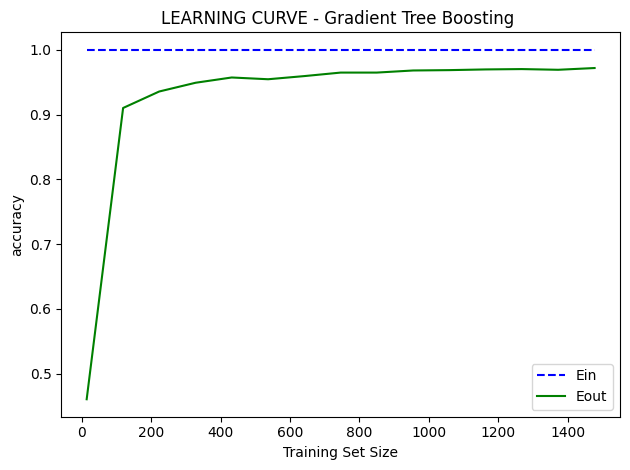

In [ ]:
show_learningCurve(X_(train), Y_(train), model_boos, "LEARNING CURVE - Gradient Tree Boosting ")

En el caso de las curvas de aprendizaje de Gradient Boosting, se pueden observar similitudes con las curvas de aprendizaje de Random Forest:

- El error de entrenamiento ($E_{in}$) se mantiene constante en 1, independientemente del tamaño de la muestra de entrenamiento. Al igual que Random Forest, Gradient Boosting tiene la capacidad de ajustarse perfectamente a los datos de entrenamiento a través de la combinación de múltiples árboles de decisión, lo que resulta en un Ein de 1.

- El error de validación ($E_{out}$) muestra un patrón similar al de Random Forest. A medida que se aumenta el tamaño de la muestra de entrenamiento, $E_{out}$ aumenta rápidamente hasta alcanzar un accuracy de 0.95 en un tamaño de muestra de 300. Esto indica que el modelo está mejorando su capacidad de generalización y está capturando patrones más generales a medida que se agregan más ejemplos al entrenamiento.

- Después de alcanzar ese punto, el $E_{out}$ continúa aumentando, pero a un ritmo más lento. Al igual que en Random Forest, esto sugiere que el modelo está aprendiendo de manera más efectiva a medida que se incrementa el tamaño de la muestra y se beneficia de una mayor diversidad en los datos de entrenamiento.

- La similitud en el comportamiento de las curvas de aprendizaje de Gradient Boosting y Random Forest se debe a que ambos algoritmos son métodos de ensamble basados en árboles de decisión. Gradient Boosting utiliza un enfoque de optimización iterativa en lugar de la combinación aleatoria de árboles como en Random Forest, es por eso que Gradient Boosting requiere de más muestra para alcanzar el mismo resultado que Random Forest.

Analizando las curvas de aprendizaje de forma general, podemos observar que no existe overfitting ya que las curvas de aprendizaje convergen y el error de validación (Eout) no disminuye al aumentar el número de ejemplos. Es importante tener curvas de aprendizaje convergentes y errores de validación estabilizados, ya que indican que el modelo no está sobreajustando los datos de entrenamiento.

In [ ]:
# Calcular el área bajo la curva ROC para cada modelo
auc_rl = roc_auc_score(Y_(train), model_rl.predict_proba(X_(train)), multi_class='ovr')
auc_mlp = roc_auc_score(Y_(train), model_mlp.predict_proba(X_(train)), multi_class='ovr')
auc_rf = roc_auc_score(Y_(train), model_rf.predict_proba(X_(train)), multi_class='ovr')
auc_boosting = roc_auc_score(Y_(train), model_boos.predict_proba(X_(train)), multi_class='ovr')

# Crear la tabla de pandas
data = {'Modelo': ['Regresión Logística', 'MLP', 'Random Forest', 'Gradient Tree Boosting'],
        'Área bajo la curva ROC': [auc_rl, auc_mlp, auc_rf, auc_boosting]}

df = pd.DataFrame(data)

display(df)

,Modelo,Área bajo la curva ROC
0,Regresión Logística,0.997559
1,MLP,0.997516
2,Random Forest,1.000000
3,Gradient Tree Boosting,1.000000


Observamos que el área bajo la curva ROC es $1$ en los dos modelos basados en árboles y casi $1$ en el resto. Esto indica de forma general nuestros modelos están aprendiendo a distinguir bien todas las clases. Este indicador que es necesario para comparar dos clasificadores, no nos da mucha información en este caso. Ya que nos puntua igual tanto a Random Forest como a Gradient Tree Boosting.

No obstante, en el siguiente apartado ordenaremos nuestros modelos con toda esta información, indicando nuestro modelo final.


# <font color='blue'>9) Mejor modelo en términos de ajuste y generalización

#### Modelo final y su $Eout$

Tras analizar nuestros conjuntos de entrenamiento con VC, obtener $Etest$ probándolo con los mejores hiperparámetros de cada modelo y analizar los resultados. Consideramos a Gradient Tree Boosting nuestro modelo final. Ya que la fusión de la función de pérdida (cross-entropy error) con el desarrollo a partir de la construcción de árbol de clasificación llevan a obtener un hiperplano no lineal que se adapta (viendo los resultados) de forma casi óptima a la muestra dada.

Los motivos es la mejora adaptativa con gradiente descendente para encontrar la separación óptima, con el buen manejo de ruido y de clases en principio poco separables que nos brinda esta construcción de árboles. Por ejemplo, en extracciones de regiones 3x3 píxeles con características muy similares, donde el cambio en su posición D-dimensional es muy sutil. Este equilibrio es una de las propiedades que nos llevan a elegir frente a otros modelos basados en árboles (Random Forest) ya que nos garantiza una buena generalización sin perder una buena clasificación.

A continuación entrenamos nuestro modelo final, con los datos al completo.

In [ ]:
all_data = pd.concat([train, test], axis=0, join='inner')
all_data = all_data.reset_index(drop=True)

model_boos.fit(X_(all_data), Y_(all_data))
print('MODELOS FINAL (GRADIENT TREE BOOSTING): Importancia encontrada por el modelo a cada característica')
print()
print(model_boos.feature_importances_)

Podemos asegurar que el $Eout$ que este modelo cumple $Eout \geq Etest$ por lo tanto nuestro $Eout \geq 98\%$ en accuracy.

#### Compromisos a tener en cuenta

El resultado anterior se basa en el modelo de partición de conjuntos que hemos tomado en el Punto 1. Emplear un conjunto de test mayor o menor tiene sus efectos:
- Un conjunto de test mayor implica una mejor aproximación a $Eout$. Sin embargo, el precio a pagar es un peor entrenamiento, dando peores resultados de clasificación.
- Un conjunto de test menor implica tener un conjunto de entrenamiento mayor que por consecuencia mejor entrenamiento. Aunque una aproximación a $Eout$ más pobre.

Otro compromiso es el uso de protocolos de validación como el uso de validación cruzada (VC) y su efecto en cómo de optimista ó pesimista es nuestro modelo. En nuestro caso, vemos que VC nos da una estimación pesimista frente a nuestro valor aproximado de $Eout$. Esto un buen indicador ya que los modelos no deberían sobrestimar el verdadero valor de $Eout$.

Un proyecto de aprendizaje automático en realidad es algo bastante complejo no creemos que existan unos pasos concretos que dar para obtener resultados, viendo como un buena plantilla los que se nos propusieron para el trabajo.

Pero quizá la clave reside en manejar bien la línea más fina de error, ser capaz de entender muy bien el problema sin implicarte en él, es decir, siempre siendo lo más frío posible a los datos y los modelos. Y además tener el conocimiento suficiente sobre los modelos y técnicas para poder entender todo el proceso.